# Lab 2: Classification
### Ryan Bass, Brett Benefield, Cho Kim, Nicole Wittlin

<a id="top"></a>
## Contents
* Data Preparation
    * <a href="#Prep1">Data Preparation Part 1</a>
    * <a href="#Prep2">Data Preparation Part 2</a>
* Modeling and Evaluation
    * <a href="#Model1">Modeling and Evaluation 1</a>
    * <a href="#Model2">Modeling and Evaluation 2</a>
    * <a href="#Model3">Modeling and Evaluation 3</a>
    * <a href="#Model4">Modeling and Evaluation 4</a>
    * <a href="#Model5">Modeling and Evaluation 5</a>
    * <a href="#Model6">Modeling and Evaluation 6</a>
* <a href="#Deployment">Deployment</a>
* <a href="#Exceptional">Exceptional Work</a>


In [2]:
%matplotlib notebook

import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import yellowbrick as yb
import matplotlib.pyplot as plt
from math import sqrt
from pprint import pprint
from time import time
from datetime import datetime
from sklearn import metrics as mt
from sklearn import neighbors
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectPercentile, f_regression, mutual_info_regression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, f1_score, roc_auc_score, mean_absolute_error, make_scorer, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, Binarizer, scale
from sklearn.svm import LinearSVC, NuSVC, SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier, RidgeClassifier, LinearRegression
from sklearn.linear_model import Ridge, Lasso, LassoCV
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold, GridSearchCV, cross_validate, RandomizedSearchCV
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ClassPredictionError, ROCAUC
from yellowbrick.features import Rank1D, Rank2D, RFECV
from yellowbrick.features.importances import FeatureImportances
from yellowbrick.model_selection import ValidationCurve, LearningCurve
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.regressor.alphas import AlphaSelection

### Slack Integration

In [9]:
# Some setup is required before you can use this because token must be kept private
# I also need to add your name and unique identifier to the dictionary userID below
import os
from slackclient import SlackClient
from dotenv import load_dotenv

load_dotenv()

userID = {"brett": "UAN6UQEVC", "ryan": "UALUD69AB"}

#slackToken = os.environ["SLACK_BOT_TOKEN"]
#sc = SlackClient(slackToken)

def sendSlackMessage(msg, user):
    result = sc.api_call(
    "chat.postMessage",
    channel=userID[user.lower()],
    text=msg)
    
    if (not result['ok']):
        print("Error: {}".format(result))

### Supporting Functions

In [10]:
# Source: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.show()
    
def getTopCoefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    feature_names = np.array(feature_names)
    return feature_names[top_coefficients]

# Source: https://stackoverflow.com/questions/39812885/retain-feature-names-after-scikit-feature-selection
def percentile_threshold_selector(data, percent=10):
    selector = SelectPercentile(f_classif, percentile = percent)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def scale_data(data):
    temp = scaler.fit(data)
    data = pd.DataFrame(temp, columns = data.columns)
    return data

# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

# rmse, mape functions take from :https://github.com/jakemdrew/EducationDataNC/blob/master/Other%20Projects/iPython%20Notebooks/Machine%20Learning/High%20School%20Minority%20Percentage%20February%202018.ipynb
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               }

In [42]:
# code used to evaluate regression models used
# code from Dr. Drew github: https://github.com/jakemdrew/EducationDataNC/blob/master/Other%20Projects/iPython%20Notebooks/Machine%20Learning/High%20School%20Minority%20Percentage%20February%202018.ipynb

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults

In [13]:
# Brett's directory
# Laptop
%cd "C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets"

# Ryan's directory
#%cd "C:\Users\Clovis\Documents\7331DataMining\EducationDataNC\2017\Machine Learning Datasets"

# Cho's directory
#%cd "/Users/chostone/Documents/Data Mining/7331DataMining/EducationDataNC/2017/Machine Learning Datasets"

# NW directory
#%cd "C:\Users\Nicole Wittlin\Documents\Classes\MSDS7331\Project\2017\Machine Learning Datasets"
dfPublicHS = pd.read_csv("PublicHighSchools2017_ML.csv")

C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets


<a href="#top">Back to Top</a> 
## Data Preparation
<a id="Prep1"></a>
### Data Preparation Part 1

For our analysis, we used the PublicHighSchools2017_ML.csv dataset available in Dr. Jake Drew's Github repository. This dataset was already preprocessed for machine learning by Dr. Drew and went through the following transformations for the school dataset within the NCEA repository:
1. Missing student body racial compositions are imputed using district averages.
2. Columns that have the same value in every single row are deleted.
3. Columns that have a unique value in every single row (all values are different) are deleted.
4. Empty columns (all values are NA or NULL) are deleted.
5. Numeric columns with more than the percentage of missing values specified by the *missingThreshold* parameter.
6. Remaining numeric, non-race columns with missing values are imputed / populated with 0.  In many cases, schools are not reporting values when they are zero. However, mean imputation or some other more sophisticated strategy might be considered here.
7. Categorical / text based columns with > *uniqueThreshold* unique values are deleted.
8. All remaining categorical / text based columns are one-hot encoded.  In categorical columns, one-hot encoding creates one new boolean / binary field per unique value in the target column, converting all categorical columns to a numeric data type. 
9. Duplicated or highly similar columns with > 95% correlation are delelted.    

(The above list is from https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Machine%20Learning%20Datasets/Source%20Code/PublicHighSchools2017_ML.ipynb)

We did additional pre-processing for the basis of some of our models. There are 403 columns in our dataset. We dropped any variables that have zero variance and only dropped one variable (`ACTWorkKeys_SilverPlus_LEP`). All of the values were zero for this variable. We also wanted to remove highly correlated variables to reduce multi-collinearity. For a Pearson R threshold of 0.8, we removed any variables where the `r` value was greater than `0.8`. As a result, we dropped 124 highly correlated variables in the code blocks below. We also removed all columns with ACT in the column name except the composite ACT score column to reduce bias in our model. We also dropped We used this dataset to build the k-nearest neighbor and random forest models. For the SVR models we took a more complex approach to find the best model with the lowest MAE/RMSE. 

In [14]:
# Credit: https://www.kaggle.com/saravanann/santander
# Drop any columns that have zero variance
totalColNum = dfPublicHS.shape[1]
sel = VarianceThreshold()
sel.fit(dfPublicHS)

keepCols = sel.get_support(indices=True)
dfColIndex = np.arange(dfPublicHS.columns.size)
dropCol = np.delete(dfColIndex, keepCols)
dfPublicHS = dfPublicHS.drop(dfPublicHS.columns[dropCol], axis = 1)

print("Columns Dropped: {}".format(len(dropCol)))

Columns Dropped: 1


In [15]:
# Create correlation matrix
dfCorr = dfPublicHS.corr('pearson').abs()

In [10]:
## source for code below: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/ ##

# Select upper triangle of correlation matrix
upper = dfCorr.where(np.triu(np.ones(dfCorr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop Columns
dfDropped = dfPublicHS.drop(columns = to_drop, axis = 1)

print("Columns dropped: {}".format(len(to_drop)))
to_drop

Columns dropped: 124


['lea_state_perpupil_num',
 '4-Year Cohort Graduation Rate Score',
 'ACTMath_ACTBenchmark_All',
 'ACTScience_ACTBenchmark_All',
 'ACTWorkKeys_SilverPlus_All',
 'ACTWriting_ACTBenchmark_All',
 'EOCSubjects_CACR_All',
 'ACTCompositeScore_UNCMin_Female',
 'ACTEnglish_ACTBenchmark_Female',
 'ACTMath_ACTBenchmark_Female',
 'ACTReading_ACTBenchmark_Female',
 'ACTScience_ACTBenchmark_Female',
 'ACTWorkKeys_SilverPlus_Female',
 'EOCBiology_CACR_Female',
 'EOCEnglish2_CACR_Female',
 'GraduationRate_5yr_Female',
 'ACTCompositeScore_UNCMin_Male',
 'ACTMath_ACTBenchmark_Male',
 'ACTScience_ACTBenchmark_Male',
 'ACTWorkKeys_SilverPlus_Male',
 'ACTWriting_ACTBenchmark_Male',
 'EOCBiology_CACR_Male',
 'EOCEnglish2_CACR_Male',
 'EOCMathI_CACR_Male',
 'ACTMath_ACTBenchmark_AmericanIndian',
 'ACTWorkKeys_SilverPlus_AmericanIndian',
 'ACTWriting_ACTBenchmark_AmericanIndian',
 'EOCBiology_CACR_AmericanIndian',
 'EOCEnglish2_CACR_AmericanIndian',
 'EOCMathI_CACR_AmericanIndian',
 'GraduationRate_4yr_Americ

In [11]:
#want to delete any remaining variables related to the ACT score (such as ACT benchmarks) to not bias our model
dfDropped['Score'] = dfDropped['ACT Score']
dropCols = dfDropped.filter(regex = r'ACT')

dfDropped.drop(dropCols, axis = 1, inplace = True)

dfDropped['ACT_Score'] = dfDropped['Score']
del dfDropped['Score']

#create a second dataframe since targets will be different for ACT and %college enrolled
dfDroppedSchPctModels = dfDropped

In [12]:
dfDropped['ACT_Score'].describe()

count    470.000000
mean      59.182979
std       22.639111
min        0.000000
25%       46.000000
50%       59.000000
75%       73.000000
max      100.000000
Name: ACT_Score, dtype: float64

<a href="#top">Back to Top</a> 
<a id="Prep2"></a>
### Data Preparation Part 2

After removing columns, we are left with 247 columns in our dfDropped dataset. 

For the two tasks, we created two dataframes since the target variable is different for each task. For predicting ACT scores, we drop the composite ACT score value from dfDropped before building our model. The dfDroppedSchPctModels dataframe is used for predicting the percentage of post-secondary enrollment for high school graduates.

<a href="#top">Back to Top</a> 
## Modeling and Evaluation
<a id="Model1"></a>
### Modeling and Evaluation 1

### Evaluation Metrics
Depending on the types of model, there are different metrics that can be used to analyze the predictive capability of the model. Below are common metrics used to evaluate models. For this analysis, we are using K-Nearest Neighbor, Random Forest, and Support Vector Regression, all regression type models. The following metrics are commonly used for regression models, and therefore, each is an appropriate metric to determine optimal model performance for our analysis.

#### Root Mean Squared Error
The Root Mean Squared Error (RMSE) is a metric that measures the average magnitude of a model's error, using a quadratic scoring rule. It is the square root of the average of the squared differences between prediction and actual observation. The metric can range from 0 to infinity and is expressed in the units of the variable of interest. As a negatively-oriented score, a lower value is better. The metric tends to penalize the model more if it is not predicting low or high ranges very well.

#### Mean Absolute Error
The Mean Absolute Error (MAE) measures the average magnitude of the errors in a set of predictions, without considering the director. It is the average over the test sample of the absolute differences between prediction and actual observation, where all individual differences have equal weight. The error is expressed in the units of the variable of interest and can range from 0 to infinity. The optimal values are lower values.

Citation for RMSE and MAE: https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d

#### Mean Absolute Percentage Error
The Mean Absolute Percentage Error (MAPE) is measure of prediction accuracy, similar to MAE, but expressing accuracy in terms of a percentage. It allows for the comparison of models with totally different response variables but has several significant drawbacks. These include: MAPE being undefined when the actual value is 0; MAPE heavily penalizes negative errors, more so than positive errors; and MAPE is biased to select models whose forecasts are too low.

Citation for MAPE: https://en.wikipedia.org/wiki/Mean_absolute_percentage_error; https://arxiv.org/pdf/1605.02541.pdf

<a href="#top">Back to Top</a> 
<a id="Model2"></a>
### Modeling and Evaluation 2

To divide our data into training and test splits, we elected to use the ShuffleSplit function in SciKit Learn with 80% designated for training and 20% for testing. ShuffleSplit uses repeated holdout and is a variation of k-fold cross validation. It is frequently referred to as repeated random test-train splits. We set up 10 folds, and the function split our data into the 80/20 training and test sets. Then, it repeated the specified number of times defined in the n-splits parameter in ShuffleSplit, which was the 10 folds.

Our data set is quite large, and our models may take considerable time to run. With our data and analysis plan, we decided ShuffleSplit is the best option because it is a faster function and reduces variance appropriately, when compared to other methods such as k-fold cross validation. We found good performance with ShuffleSplit.

Citation: https://machinelearningmastery.com/evaluate-performance-machine-learning-algorithms-python-using-resampling/

<a href="#top">Back to Top</a> 
<a id="Model3"></a>
### Modeling and Evaluation 3

### Model 1 - KNN: ACT

To predict ACT scores we have to first make ACT_Score the target in our data set. Then we will create our 10-fold cross validation using ShuffleSplit to randomly select the data for the folds. The folds will be based on an 80/20 split train to test data.

In [13]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'ACT_Score' in dfDropped:
    y = dfDropped['ACT_Score'].values # get the labels we want
    del dfDropped['ACT_Score'] # get rid of the class label
    X = dfDropped.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, random_state=0)
                         
print(cv_object)

ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None)


We then have to create our test and training data sets to score our test models.

In [14]:
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]

For k-nearest neighbors we must scale the data.

In [19]:
# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)
X_scaled = scl_obj.transform(X)

For our first k-nearest neighbors model we'll make an array to test the mean absolute error and root mean square error for each value of k (number of nearest neighbors) in a standard KNN regression model

In [28]:
rmse_val = [] #to store rmse values for different k
mae_val = []  #to store mae values for different k
for K in range(20):
    K = K + 1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train_scaled, y_train)  #fit the model
    pred = model.predict(X_test_scaled) #make prediction on test set
    rmse = sqrt(mean_squared_error(y_test, pred)) #calculate rmse
    mae = mean_absolute_error(y_test, pred)
    rmse_val.append(rmse) #store rmse values
    mae_val.append(mae) #store mae values
    print('For k =' ,K , 'RMSE: ',rmse, 'MAE: ',mae)

For k = 1 RMSE:  16.131111739661556 MAE:  12.127659574468085
For k = 2 RMSE:  14.60544928908968 MAE:  10.914893617021276
For k = 3 RMSE:  13.574938666928654 MAE:  10.134751773049645
For k = 4 RMSE:  12.74762702156174 MAE:  9.678191489361701
For k = 5 RMSE:  12.66818766530573 MAE:  9.457446808510637
For k = 6 RMSE:  12.540678491265 MAE:  9.484042553191488
For k = 7 RMSE:  12.481466938402447 MAE:  9.575987841945288
For k = 8 RMSE:  12.43730286917443 MAE:  9.507978723404255
For k = 9 RMSE:  12.457376765646584 MAE:  9.576832151300238
For k = 10 RMSE:  12.490187638063832 MAE:  9.613829787234042
For k = 11 RMSE:  12.626452008035992 MAE:  9.74468085106383
For k = 12 RMSE:  12.71095630412931 MAE:  9.875886524822695
For k = 13 RMSE:  12.82573570645891 MAE:  9.930441898527006
For k = 14 RMSE:  12.999267239444066 MAE:  9.977963525835868
For k = 15 RMSE:  13.082674013291834 MAE:  10.029078014184396
For k = 16 RMSE:  13.130023734604466 MAE:  10.04122340425532
For k = 17 RMSE:  13.306639854321554 MA

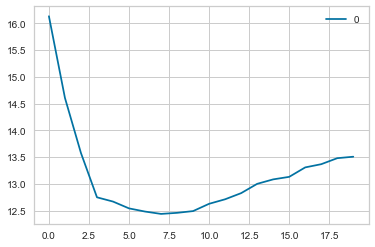

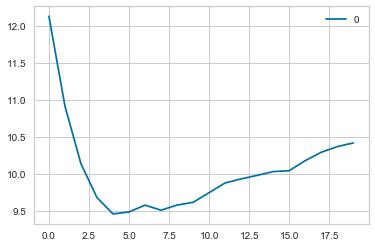

In [171]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

curve2 = pd.DataFrame(mae_val)
curve2.plot()

Since mean aboslute value (MAE) is more appropriate for our data set we will use this. The smallest MAE value was found for k = 5. Let's fit and evaluate the model.

In [29]:
# train the model with mostly default settings to see how accurate it is
# choosing k=5 and default settings to run intial model
dfDropped_KNNr = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski')
dfDropped_KNNr.fit(X_train_scaled, y_train)  # train object

y_hat = dfDropped_KNNr.predict(X_test_scaled) # get test set precitions

In [30]:
#evaluate mostly standard KNN model
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(dfDropped_KNNr, X_scaled, y, cv_object)

The average MAE for all cv folds is: 			 9.5488
The average MAE percentage (MAPE) for all cv folds is: 	 18.015
The average RMSE for all cv folds is: 			 13.011
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,10.356291,17.170866,15.498856
1,10.451808,19.493605,13.894078
2,9.564047,16.428851,12.502409
3,9.576056,16.313857,13.128858
4,8.675811,18.791618,11.347867
5,8.946945,16.600955,12.151721
6,10.850724,20.346883,15.404554
7,8.237254,14.880154,10.500932
8,9.423599,18.304809,13.030673
9,9.405150,21.820358,12.652826


Now that we've done a mostly standard k-nearest neighbors model lets use yellowbrick and GridSearchCV to tune hyperparameters to attempt to make a better model. First we'll use yellowbrick to visualize the continuous parameters to look for ranges of values that will decrease the mean absolute error as close to zero as possible. These visualizations will help narrow the parameter's ranges needed to set in a GridSearchCV. This will lessen the computational time needed to compute an optimal model.

First we'll look at the parameter n_neighbors, which is the k in k-nearest neighbors. This is the number of data points that will be retrieved around the vicinity of new sample's value, those data points will be averaged in regression to yield a prediction for the new sample.

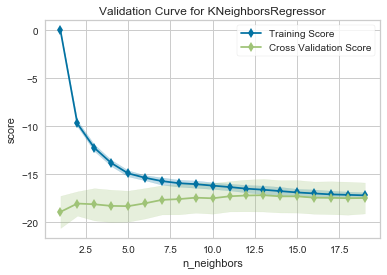

In [175]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    neighbors.KNeighborsRegressor(), param_name='n_neighbors',
    param_range=np.arange(1, 20), cv=cv_object, scoring=mae_scorer
)

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

This shows that our error will not get better as the k-nearest neighbors increases past around k=15. Our GridSearchCV can now be refined so save computing time.

Now we'll look at leaf_size to see if score is effected even though it effects the speed of the tree construction and queries.

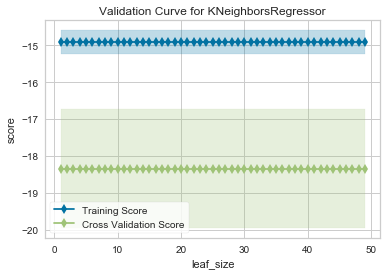

In [176]:
viz = ValidationCurve(
    neighbors.KNeighborsRegressor(), param_name='leaf_size',
    param_range=np.arange(1, 50), cv=cv_object, scoring=mae_scorer
)

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

This shows that leaf_size has no effect on the error. Values from 1-150 were also visualized with no change. Therefore the default leaf_size will be used (30).

The last real continuous parameter we can visualize is p, the power parameter. It is set to 1 for manhattan distance and 2 for euclidean distances. For any other number minkowski is used.

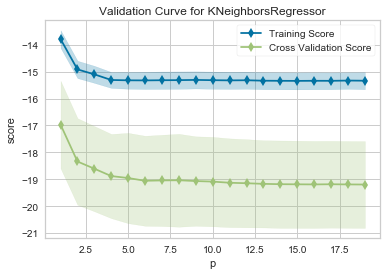

In [177]:
viz = ValidationCurve(
    neighbors.KNeighborsRegressor(), param_name='p',
    param_range=np.arange(1, 20), cv=cv_object, scoring=mae_scorer
)

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

The lowest error is seen with p=1, and error levels off after p=6. We will include this entire range in the GridSearch.

In [179]:
#source for hyper parameter code: https://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/

# define the parameter values that should be searched
k_range = list(range(1, 15))

p_range = list(range(1, 6))

# Another parameter besides k that we might vary is the weights parameters
# default options --> uniform (all points in the neighborhood are weighted equally)
# another option --> distance (weights closer neighbors more heavily than further neighbors)

# we create a list
weight_options = ['uniform', 'distance']

algorithm_options = ['auto', 'ball_tree', 'kd_tree', 'brute']


# create a parameter grid: map the parameter names to the values that should be searched
# dictionary = dict(key=values, key=values)
param_grid = dict(n_neighbors = k_range, weights = weight_options, 
                  algorithm = algorithm_options, p=p_range)

# instantiate and fit the grid
# exhaustive grid-search because it's trying every combination
# 10-fold cross-validation is being performed 30 x 2 = 60 times

grid = GridSearchCV(neighbors.KNeighborsRegressor(), param_grid, cv = cv_object, 
                    scoring = mae_scorer, n_jobs = -1, verbose = 2)
grid.fit(X_train_scaled, y_train)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

Fitting 10 folds for each of 760 candidates, totalling 7600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 703 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1083 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 2197 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 3023 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 3970 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 4825 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 5750 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 7593 out of 7600 | elapsed: 27.3min remaining:    1.4s


-8.527177552640833
{'algorithm': 'auto', 'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=1,
          weights='distance')


[Parallel(n_jobs=-1)]: Done 7600 out of 7600 | elapsed: 27.3min finished


Now that we have the best parameters we could have for the model we'll use this for the final model using the full data.

In [22]:
gridEstimator = grid.best_estimator_

EvaluateRegressionEstimator(gridEstimator, X_scaled, y, cv_object)

The average MAE for all cv folds is: 			 8.6738
The average MAE percentage (MAPE) for all cv folds is: 	 17.137
The average RMSE for all cv folds is: 			 11.7
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,8.878367,15.095967,13.426943
1,9.307490,18.291345,12.606643
2,8.550165,16.754008,11.125511
3,7.209622,13.705857,9.580950
4,8.323006,17.929500,11.506956
5,8.228658,15.007781,11.106888
6,8.779910,18.635852,12.088774
7,9.179677,17.546625,11.209486
8,8.552001,16.097165,11.712873
9,9.729214,22.309523,12.630859


A MAE of 9.5488 from the k=5 default model to the hypertuned model gave a MAE of 8.6738, a 9% better MAE.

<IPython.core.display.Javascript object>


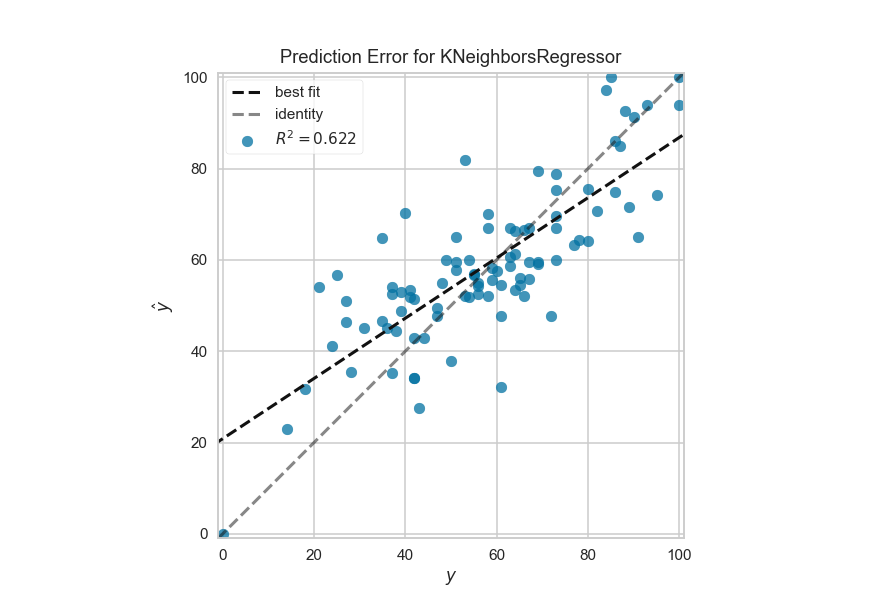

In [44]:
#let's see how well our model fits our data visually
KNN = neighbors.KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=1,
          weights='distance')

visualizer = PredictionError(KNN)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

Here we can see how much error is in our predictions with a MAE of 8.6738.
K-nearest neighbors must have it's variables scaled to provide an accurate prediction. This is a fairly accurate model that takes little computational power to conduct as well.

### Model 2 - KNN: Post-secondary enrollment Percentage

Now since we want to create regression models for % of students who enrolled in college after high school we'll have to make that the target in our dataframe. We'll follow the same steps to create a 10-fold cross validation as before too. To replicate our previous logistic regression model (MiniLab notebook) we will prepare our data the same way. This includes erasing variables that gave the model bias when trying to predict the % enrolled.

In [23]:
#first must rename our target response variable so it is not dropped
dfDroppedSchPctModels['schoolPctTarget'] = dfDroppedSchPctModels['ALL_All Students (Total or Subtotal_ENROLL_sch_pct']

#find all variables with sch_pct in the name
dropCols = dfDroppedSchPctModels.filter(regex = r'sch_pct')

#drop all said columns
dfDroppedSchPctModels.drop(dropCols, axis = 1, inplace = True)

# These names seem to cause problems so let's give them friendlier names
renameCols = {'_1yr_tchr_trnovr_pct': 'One_yr_tchr_trnovr_pct',
              '0-3 Years_LEA_Exp_Pct_Prin': 'less_3_years_LEA_Exp_Pct_Prin',
              '10+ Years_LEA_Exp_Pct_Prin': 'ten_plus_years_LEA_Exp_Pct_Prin',
              '4-10 Years_LEA_Exp_Pct_Prin': 'four_plus_years_LEA_Exp_Pct_Prin',
              '4-Year_Cohort_Graduation_Rate_Score': 'four_Year_Cohort_Graduation_Rate_Score',
              '_1_to_1_access_Yes': 'one_to_one_access_yes',
              '4_10_Years_LEA_Exp_Pct_Prin': 'Four_to_Ten_Years_Exp_Pct_prin',
              '10+_Years_LEA_Exp_Pct_Prin': 'Ten_Plus_Years_LEA_Exp_Pct_prin',
              '0_3_Years_LEA_Exp_Pct_Prin': 'One_to_three_lea_exp_pct_prin'}

# Remove any trailing white spaces
dfDroppedSchPctModels.columns = dfDropped.columns.str.strip()

# Remove any spaces, slashes, or hyphens
dfDroppedSchPctModels.columns = dfDropped.columns.str.replace(r' |/|-|,|\+|:', "_")

# Rename columns
dfDroppedSchPctModels.rename(columns=renameCols, inplace = True)

In [24]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'schoolPctTarget' in dfDroppedSchPctModels:
    ySchPct = dfDroppedSchPctModels['schoolPctTarget'].values # get the labels we want
    del dfDroppedSchPctModels['schoolPctTarget'] # get rid of the class label
    XSchPct = dfDroppedSchPctModels.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 10
num_instances = len(ySchPct)
cv_object2 = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, random_state=1)
                         
print(cv_object2)

ShuffleSplit(n_splits=10, random_state=1, test_size=0.2, train_size=None)


We'll need to create new training and test data sets as well.

In [25]:
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object2.split(XSchPct, ySchPct): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    XSchPct_train = XSchPct[train_indices]
    ySchPct_train = ySchPct[train_indices]
    
    XSchPct_test = XSchPct[test_indices]
    ySchPct_test = ySchPct[test_indices]

And finally we'll scale the data. Now our data is prepared to begin modeling.

In [26]:
# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(XSchPct_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

XSchPct_train_scaled = scl_obj.transform(XSchPct_train) # apply to training
XSchPct_test_scaled = scl_obj.transform(XSchPct_test) # apply those means and std to the test set (without snooping at the test set values)
XSchPct_scaled = scl_obj.transform(XSchPct)

Like with the ACT model we'll make an array of values to set our k for our KNN model.

In [236]:
rmse_val = [] #to store rmse values for different k
mae_val = []  #to store mae values for different k
for K in range(20):
    K = K + 1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(XSchPct_train_scaled, ySchPct_train)  #fit the model
    pred = model.predict(XSchPct_test_scaled) #make prediction on test set
    rmse = sqrt(mean_squared_error(ySchPct_test, pred)) #calculate rmse
    mae = mean_absolute_error(ySchPct_test, pred)
    rmse_val.append(rmse) #store rmse values
    mae_val.append(mae) #store mae values
    print('For k =' ,K , 'RMSE: ',rmse, 'MAE: ',mae)

For k = 1 RMSE:  13.652539160057042 MAE:  9.664053326344781
For k = 2 RMSE:  10.805611944522708 MAE:  8.20730690878794
For k = 3 RMSE:  9.833898892064768 MAE:  7.372578104160579
For k = 4 RMSE:  10.215141305451366 MAE:  7.679368585940749
For k = 5 RMSE:  10.278050435473917 MAE:  7.729420269306957
For k = 6 RMSE:  10.244250564313747 MAE:  7.658751862740578
For k = 7 RMSE:  10.498998609894606 MAE:  7.847735285223784
For k = 8 RMSE:  10.448966071821305 MAE:  7.704964899200307
For k = 9 RMSE:  10.69311025646381 MAE:  7.844433648096743
For k = 10 RMSE:  10.513804669809995 MAE:  7.841122569230717
For k = 11 RMSE:  10.563168904866174 MAE:  7.859895378177099
For k = 12 RMSE:  10.565140148659328 MAE:  7.835495004841487
For k = 13 RMSE:  10.381288513175528 MAE:  7.633993046284816
For k = 14 RMSE:  10.545396482579372 MAE:  7.700971089880511
For k = 15 RMSE:  10.721320532873804 MAE:  7.6904158652005545
For k = 16 RMSE:  10.730970502043208 MAE:  7.686789771274011
For k = 17 RMSE:  10.82332697546916

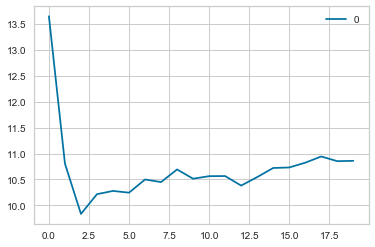

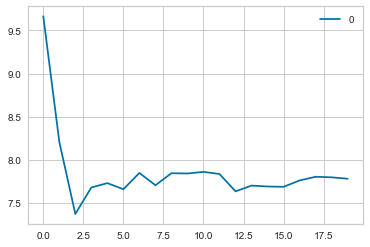

In [237]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

curve2 = pd.DataFrame(mae_val)
curve2.plot()

We find that k=3 yieled the lowest MAE so we will use that for our intiail model.

In [55]:
# train the model with mostly default settings to see how accurate it is
# choosing k=3 and default settings to run intial model
dfDroppedSchPctModels_KNNr = neighbors.KNeighborsRegressor(n_neighbors=3, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski')
dfDroppedSchPctModels_KNNr.fit(XSchPct_train_scaled, ySchPct_train)  # train object

ySchPct_hat = dfDroppedSchPctModels_KNNr.predict(XSchPct_test_scaled) # get test set precitions

In [32]:
#evaluate mostly standard KNN model
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(dfDroppedSchPctModels_KNNr, XSchPct_scaled, ySchPct, cv_object2)

The average MAE for all cv folds is: 			 8.651
The average MAE percentage (MAPE) for all cv folds is: 	 15.743
The average RMSE for all cv folds is: 			 12.363
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,8.446718,15.146179,12.042882
1,8.956018,18.136081,11.732913
2,9.620595,18.035254,15.319657
3,8.059144,14.423797,11.996684
4,7.180177,14.615542,9.645760
5,8.852806,17.049022,12.284364
6,8.350191,14.894692,11.945727
7,9.329185,16.835713,13.189800
8,9.743906,13.172333,14.975721
9,7.971508,15.119159,10.499291


Our initial model by just picking k = 3 yielded a MAE of 8.651.

Now that we've ran a mostly standard KNN model we'll now prepare to run a optimized model using yellowbrick to narrow parameters and GridSearchCV to find the best ones.

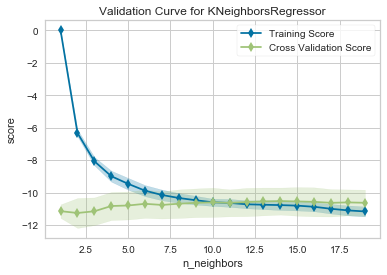

In [240]:
viz = ValidationCurve(
    neighbors.KNeighborsRegressor(), param_name='n_neighbors',
    param_range=np.arange(1, 20), cv=cv_object2, scoring=mae_scorer
)

# Fit and poof the visualizer
viz.fit(XSchPct, ySchPct)
viz.poof()

We can see that k=1 gives the lowest score possible and sharply declines after this.

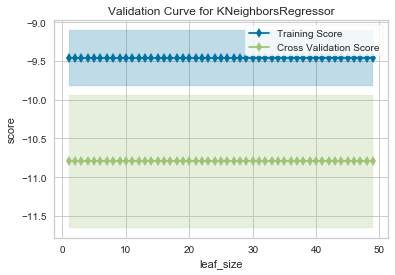

In [241]:
viz = ValidationCurve(
    neighbors.KNeighborsRegressor(), param_name='leaf_size',
    param_range=np.arange(1, 50), cv=cv_object2, scoring=mae_scorer
)

# Fit and poof the visualizer
viz.fit(XSchPct, ySchPct)
viz.poof()

Since leaf size has no effect on the MAE we'll leave it at its default setting (30).

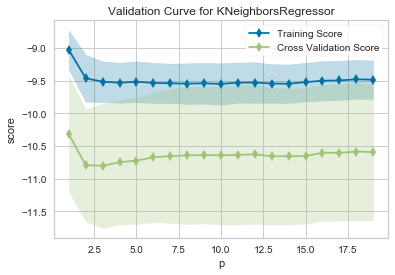

In [242]:
viz = ValidationCurve(
    neighbors.KNeighborsRegressor(), param_name='p',
    param_range=np.arange(1, 20), cv=cv_object2, scoring=mae_scorer
)

# Fit and poof the visualizer
viz.fit(XSchPct, ySchPct)
viz.poof()

The MAE training score for the p parameter levels off at about 3 while it's cross validation is stable after 6. A range for GridSearchCV will be set between 1 and 6.

In [243]:
#source for hyper parameter code: https://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/

# define the parameter values that should be searched
k_range = list(range(1, 10))

p_range = list(range(1, 6))

# Another parameter besides k that we might vary is the weights parameters
# default options --> uniform (all points in the neighborhood are weighted equally)
# another option --> distance (weights closer neighbors more heavily than further neighbors)

# we create a list
weight_options = ['uniform', 'distance']

algorithm_options = ['auto', 'ball_tree', 'kd_tree', 'brute']


# create a parameter grid: map the parameter names to the values that should be searched
# dictionary = dict(key=values, key=values)
param_grid = dict(n_neighbors = k_range, weights = weight_options, 
                  algorithm = algorithm_options, p=p_range)

# instantiate and fit the grid
# exhaustive grid-search because it's trying every combination
# 10-fold cross-validation is being performed 30 x 2 = 60 times

KNNgrid_SchPct = GridSearchCV(neighbors.KNeighborsRegressor(), param_grid, 
                              cv = cv_object2, scoring = mae_scorer, 
                              n_jobs = -1, verbose = 2)
KNNgrid_SchPct.fit(XSchPct_train_scaled, ySchPct_train)

# examine the best model
print(KNNgrid_SchPct.best_score_)
print(KNNgrid_SchPct.best_params_)
print(KNNgrid_SchPct.best_estimator_)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 423 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 774 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1308 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1987 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 2643 tasks      | elapsed:  9.2min


-9.672158562417337
{'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=1,
          weights='distance')


[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 11.2min finished


Now that our hypertuned parameters are set, let's analyze our model using the full dataset.

In [35]:
KNNgridEstimator_SchPct = KNNgrid_SchPct.best_estimator_

EvaluateRegressionEstimator(KNNgridEstimator_SchPct, XSchPct_scaled, ySchPct, cv_object2)

The average MAE for all cv folds is: 			 8.2894
The average MAE percentage (MAPE) for all cv folds is: 	 14.971
The average RMSE for all cv folds is: 			 12.325
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,7.901134,14.992275,11.218716
1,8.869291,17.214462,12.792765
2,8.223408,15.380119,13.266193
3,7.786228,15.116667,11.545265
4,7.306069,13.861833,10.070145
5,8.042434,15.432645,12.355638
6,8.737494,15.591456,12.715662
7,9.271599,15.930253,14.135579
8,9.560677,12.750886,15.027175
9,7.196033,13.440226,10.125522


After setting the parameter ranges for a GridSearchCV to find the optimal parameters for our KNN model (parameter hypertuning) it gave us a slightly better MAE of 8.2894.
This is only a 4% better MAE than our initial model. 

Now let's visualize how well our model predicts.

<IPython.core.display.Javascript object>


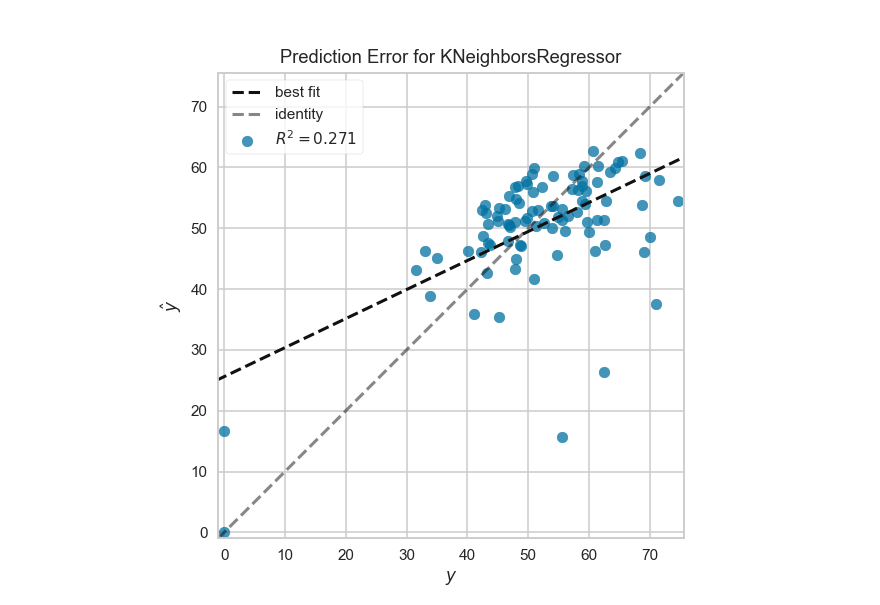

In [51]:
#lets visually see how well our model fits
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()
KNNact = neighbors.KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=1,
          weights='distance')
visualizer2 = PredictionError(KNNact)

visualizer2.fit(XSchPct_train_scaled, ySchPct_train)  # Fit the training data to the visualizer
visualizer2.score(XSchPct_test_scaled, ySchPct_test)  # Evaluate the model on the test data
g2 = visualizer2.poof()             # Draw/show/poof the data

### Model 3 - Random Forest: ACT

Now for ACT scores lets use a Random Forest regression model instead of KNN regression. Because random forest is much more computationally intensive we'll help narrow the scope of the parameters that need to be hypertuned. As with the KNN models, to do this we'll use yellowbrick to visualize smaller error scores on each parameter.

First we'll look at n_estimators, this sets how many decision trees are in the forest. The higher the better usually, but will take much longer to compute.

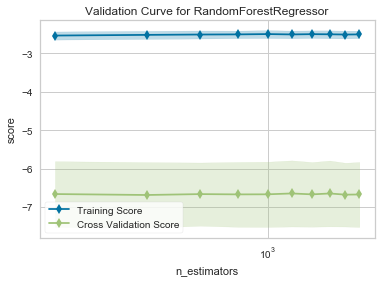

In [141]:
viz = ValidationCurve(
    RandomForestRegressor(), param_name = 'n_estimators',
    param_range = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)], 
    logx = True, cv = cv_object, scoring = mae_scorer, n_jobs = -1,
)

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

The number of estimators for the tree have a slighty better score as they increase, this will likely be the parameter that needs the widest range of values when tuning in our GridSearchCV since the range of scores is neglible in this graph.

Now we'll look at max_depth, this sets how deep the decision trees are allowed to be. If the max depth is set to none then the nodes will expand until all the leaves are pure or when all the leaves have less than the min_samples_split samples.

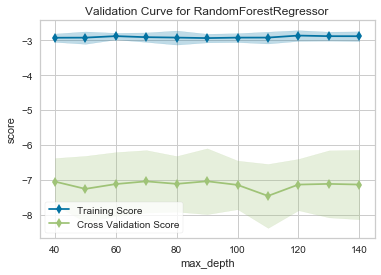

In [201]:
viz = ValidationCurve(
    RandomForestRegressor(), param_name = 'max_depth',
    param_range = [int(x) for x in np.linspace(40, 140, num = 11)], 
    cv = cv_object, scoring = mae_scorer, n_jobs = -1,
)

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

Max depth looks to have a similar output as n estimators. Because of the very little difference in scores we'll have to set a large range for this parameter in the grid search.

Next is min_samples split, which sets the minimum number of samples required to split a node.

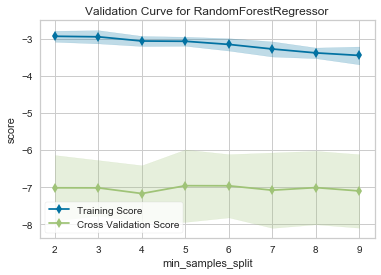

In [144]:
viz = ValidationCurve(
    RandomForestRegressor(), param_name = 'min_samples_split',
    param_range = np.arange(2, 10), 
    cv = cv_object, scoring = mae_scorer, n_jobs = -1,
)

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

For the minimum samples to split a tree it is clear the smaller the better.

The last continuous parameter we can visualize is min_samples_leaf. This parameter sets the minimum number of samples neeed to make a leaf node on both the left and right node of the split. This might effect model smoothing in regression.

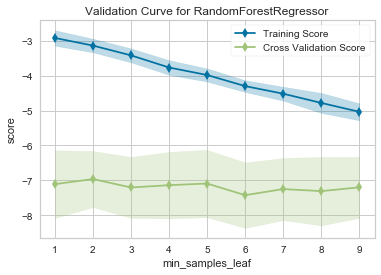

In [145]:
viz = ValidationCurve(
    RandomForestRegressor(), param_name = 'min_samples_leaf',
    param_range = np.arange(1, 10), 
    cv = cv_object, scoring = mae_scorer, n_jobs = -1,
)

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

Even more obvious than the minimum samples to split a tree are the minimum samples in a leaf needs to be as small as possible to obtain the most accurate model.

Using the information gathered from the visualizations provided by the yellowbrick package we'll first perform a RandomizedSearchCV which is similar to GridSearchCV to hypertune parameters. But instead of building every model given in the parameter range given out of the entire data set it will subset the data. This is suboptimal but provides enough information to narrow the range of hypertuning needed that can be done in a later GridSearchCV. This was not as necessary in our KNN model because KNN is a much less computationally intensive model, whereas RandomForest must generate many many decision trees (a forest!).

In [202]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(70, 140, num = 8)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'log2'], 'max_depth': [70, 80, 90, 100, 110, 120, 130, 140, None], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1, 2, 3], 'bootstrap': [True, False]}


In [204]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_randomACT = RandomizedSearchCV(estimator = rf, 
                                  param_distributions = random_grid, 
                                  n_iter = 100, cv = cv_object, verbose = 2, 
                                  random_state = 42, n_jobs = -1, 
                                  scoring = mae_scorer)

# Fit the random search model
rf_randomACT.fit(X_train_scaled, y_train)

# examine the best model
print(rf_randomACT.best_score_)
print(rf_randomACT.best_params_)
print(rf_randomACT.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 114.8min finished


-7.46473157894737
{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 130, 'bootstrap': True}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=130,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


Now let's see how well our model fits by just using the RandomizedSearchCV. Note that random forest does not need it's data to be scaled for accurate predictions.

In [50]:
# let's analyze how well the RandomizedGridSearch model predicted
gridRandomEstimatorACT = rf_randomACT.best_estimator_

EvaluateRegressionEstimator(gridRandomEstimatorACT, X, y, cv_object)

The average MAE for all cv folds is: 			 6.685
The average MAE percentage (MAPE) for all cv folds is: 	 12.6
The average RMSE for all cv folds is: 			 9.493
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,7.776851,11.123163,15.171246
1,7.359415,14.604101,10.147887
2,5.876947,10.671052,7.752013
3,6.655319,11.587565,9.321717
4,5.994096,12.317723,7.643537
5,5.910702,11.126984,7.847462
6,8.335755,16.369600,12.434063
7,5.665287,10.833576,6.876532
8,6.433426,13.030488,8.883370
9,6.841809,14.337052,8.852213


Now that we have a very accurate model from the RandomizedSearchCV function with our random forest, we will take these parameters that it chose as the best to refine the range for a full GridSearchCV which uses the entire data set to tune the parameter ranges that are given to it. This would not be feasible to do initially because of the computational time it would take to make thousands of random forest models.

In [207]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [125, 130, 135],
    'max_features': ['auto'],
    'min_samples_leaf': [1],
    'min_samples_split': [2, 3],
    'n_estimators': [850, 900, 950, 1000, 1050, 1100, 1150]
}

# Create a based model
rf = RandomForestRegressor(random_state = 40)

# Instantiate the grid search model
rf_gridACT = GridSearchCV(estimator = rf, param_grid = param_grid, 
                                cv = cv_object, n_jobs = -1, verbose = 2, 
                                scoring = mae_scorer)

# Fit the grid search to the data
rf_gridACT.fit(X_train_scaled, y_train)

# examine the best model
print(rf_gridACT.best_score_)
print(rf_gridACT.best_params_)
print(rf_gridACT.best_estimator_)

Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 34.1min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 39.7min finished


-7.480863777089784
{'bootstrap': True, 'max_depth': 125, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 850}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=125,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=850, n_jobs=None,
           oob_score=False, random_state=40, verbose=0, warm_start=False)


In [208]:
# analyze how well the GridSearchCV model based on RandomizedGridSearchCV predicted
rf_gridACT_Estimator = rf_gridACT.best_estimator_

EvaluateRegressionEstimator(rf_gridACT_Estimator, X, y, cv_object)

The average MAE for all cv folds is: 			 6.658
The average MAE percentage (MAPE) for all cv folds is: 	 12.565
The average RMSE for all cv folds is: 			 9.4587
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,7.734756,11.049434,15.127488
1,7.310013,14.464754,10.109047
2,5.880138,10.669229,7.860879
3,6.618698,11.628294,9.202362
4,5.912478,12.171405,7.521601
5,5.966258,11.319840,7.922497
6,8.208698,16.236823,12.284326
7,5.626809,10.724246,6.794118
8,6.519962,13.178357,8.945430
9,6.802578,14.208538,8.819681


Our random forest using GridSearchCV had near identical MAE and RMSE compared to the RandomizedSearchCV. The GridSearchCV decreased in MAE (better) from 6.685 to 6.658. This shows how accurate a model can be just by randomly sampling the data rather than needing the entire data set to test. To run the parameter ranges we used in RandomizedSearchCV in GridSearchCV would likely take a full day to complete.

Now let's visually see how well our GridSearchCV model predicts.

<IPython.core.display.Javascript object>


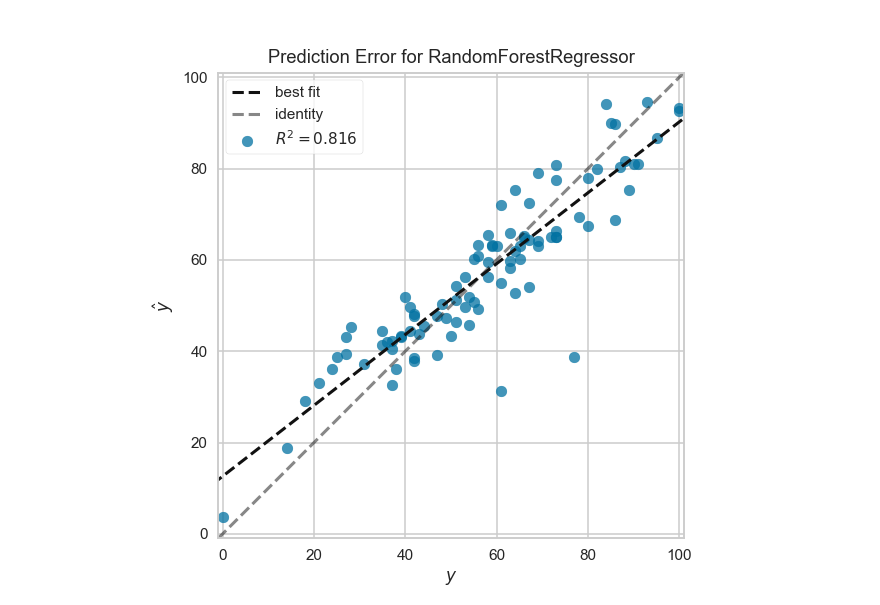

In [52]:
#let's visually see how well our hypertuned parameter random forest model fits
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

visualizer = PredictionError(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=125,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=850, n_jobs=None,
           oob_score=False, random_state=40, verbose=0, warm_start=False))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

### Model 4 - Random Forest: Post-secondary Enrollment Percentage

Now let's do the same random forest regression for the % of students who enrolled in college within 18 months of graduation from high school. Like with the ACT random forest, yellowbrick and RandomizedSearchCV will be used to help refine the model before final hypertuning of the parameters occur using GridSearchCV.

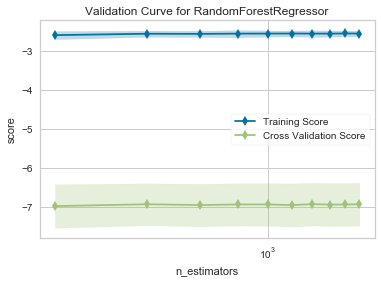

In [148]:
viz = ValidationCurve(
    RandomForestRegressor(), param_name = 'n_estimators',
    param_range = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)], 
    logx = True, cv = cv_object2, scoring = mae_scorer, n_jobs = -1,
)

# Fit and poof the visualizer
viz.fit(XSchPct, ySchPct)
viz.poof()

The parameter n estimators shows no real increase or decrease in error from 200 to 2000. There looks to be less error in the score and maybe slightly lower score from 800 to 2000, so we will narrow the range to this.

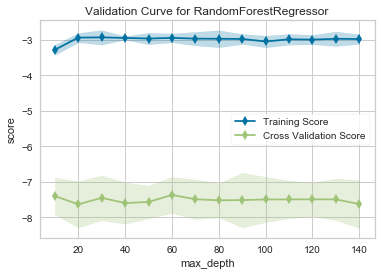

In [247]:
viz = ValidationCurve(
    RandomForestRegressor(), param_name = 'max_depth',
    param_range = [int(x) for x in np.linspace(10, 140, num = 14)], 
    cv = cv_object2, scoring = mae_scorer, n_jobs = -1,
)

# Fit and poof the visualizer
viz.fit(XSchPct, ySchPct)
viz.poof()

Similar to n estimators, there is no clear range for max depth. A range of 60 through 90 will be chosen for randomized search since they have a slightly lower score than other ranges.

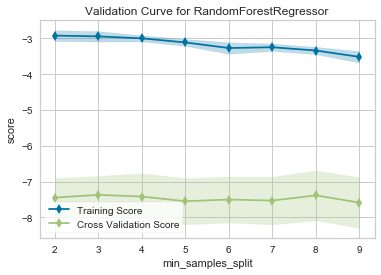

In [248]:
viz = ValidationCurve(
    RandomForestRegressor(), param_name = 'min_samples_split',
    param_range = np.arange(2, 10), 
    cv = cv_object2, scoring = mae_scorer, n_jobs = -1,
)

# Fit and poof the visualizer
viz.fit(XSchPct, ySchPct)
viz.poof()

Much more clear is the better scores for the least amount of the minimum samples split parameter. The range of 2 through 4 will be used.

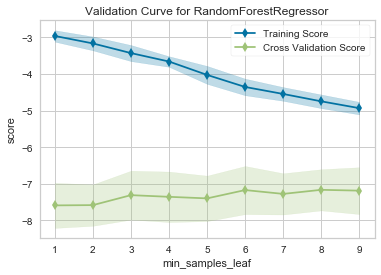

In [249]:
viz = ValidationCurve(
    RandomForestRegressor(), param_name = 'min_samples_leaf',
    param_range = np.arange(1, 10), 
    cv = cv_object2, scoring = mae_scorer, n_jobs = -1,
)

# Fit and poof the visualizer
viz.fit(XSchPct, ySchPct)
viz.poof()

Similar to minimum samples split, the minimum samples leaf parameter has a better score the less the samples are. A range of 1 through 3 will be used.

In [251]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 800, stop = 2000, num = 7)]

# Number of features to consider at every split
max_features = ['auto']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(30, 140, num = 12)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid2 = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid2)

{'n_estimators': [800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto'], 'max_depth': [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, None], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3], 'bootstrap': [True, False]}


In [252]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf2 = RandomForestRegressor(random_state=39)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_randomSchPct = RandomizedSearchCV(estimator = rf2, 
                                     param_distributions = random_grid2, 
                                     n_iter = 100, cv = cv_object2, verbose = 2, 
                                     random_state=42, n_jobs = -1, 
                                     scoring = mae_scorer)

# Fit the random search model
rf_randomSchPct.fit(XSchPct_train_scaled, ySchPct_train)

# examine the best model
print(rf_randomSchPct.best_score_)
print(rf_randomSchPct.best_params_)
print(rf_randomSchPct.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 69.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 115.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 179.5min finished


-7.277693617180782
{'n_estimators': 1400, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=1400, n_jobs=None,
           oob_score=False, random_state=39, verbose=0, warm_start=False)


In [253]:
# analyze how well the RandomizedGridSearchCV predicted
rf_randomSchPct_Estimator = rf_randomSchPct.best_estimator_

EvaluateRegressionEstimator(rf_randomSchPct_Estimator, XSchPct, ySchPct, cv_object2)

The average MAE for all cv folds is: 			 6.8676
The average MAE percentage (MAPE) for all cv folds is: 	 13.985
The average RMSE for all cv folds is: 			 10.292
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,7.298601,13.796717,12.147322
1,7.496757,16.473439,10.623253
2,6.321626,14.140076,9.782103
3,6.949730,13.706730,11.498687
4,6.282519,14.029288,8.286094
5,6.289272,14.032647,8.493712
6,6.642159,13.170266,9.308729
7,7.661940,14.908810,10.418879
8,7.512178,13.609234,12.555987
9,6.221363,11.980629,9.804706


Using the RandomizedSearchCV we find another random forest model that has a very low MAE of 6.8676. We'll refine this parameters further with a GridSearchCV now to see how much more accurate we can make this model.

In [255]:
#{'n_estimators': 1400, 'min_samples_split': 3, 'min_samples_leaf': 3, 
# 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [95, 100, 105],
    'max_features': ['auto'],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [3],
    'n_estimators': [1250, 1300, 1350, 1400, 1450, 1500, 1550]
}

# Create a based model
rf3 = RandomForestRegressor(random_state = 38)

# Instantiate the grid search model
rf_gridSchPct = GridSearchCV(estimator = rf3, param_grid = param_grid, 
                                   cv = cv_object2, n_jobs = -1, 
                                   verbose = 2, scoring = mae_scorer)

# Fit the grid search to the data
rf_gridSchPct.fit(XSchPct_train_scaled, ySchPct_train)

# examine the best model
print(rf_gridSchPct.best_score_)
print(rf_gridSchPct.best_params_)
print(rf_gridSchPct.best_estimator_)

Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 39.6min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 46.2min finished


-7.298102592504524
{'bootstrap': True, 'max_depth': 95, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 1350}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=95,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=1350, n_jobs=None,
           oob_score=False, random_state=38, verbose=0, warm_start=False)


In [256]:
# analyze how well the GridSearchCV model based on RandomizedGridSearchCV predicted
rf_gridSchPct_Estimator = rf_gridSchPct.best_estimator_

EvaluateRegressionEstimator(rf_gridSchPct_Estimator, XSchPct, ySchPct, cv_object2)

The average MAE for all cv folds is: 			 6.862
The average MAE percentage (MAPE) for all cv folds is: 	 13.972
The average RMSE for all cv folds is: 			 10.287
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,7.284857,13.785399,12.125501
1,7.491686,16.471536,10.635322
2,6.230700,14.012356,9.733732
3,6.954624,13.698964,11.552183
4,6.342430,14.114589,8.336878
5,6.288323,14.016830,8.458938
6,6.631119,13.119772,9.287885
7,7.684002,14.941549,10.421547
8,7.520110,13.638213,12.551879
9,6.192218,11.924499,9.768278


This GridSearchCV results were nearly identical to the RandomizedGridSearchCV. So let's check to see visually how well this predicts.

<IPython.core.display.Javascript object>


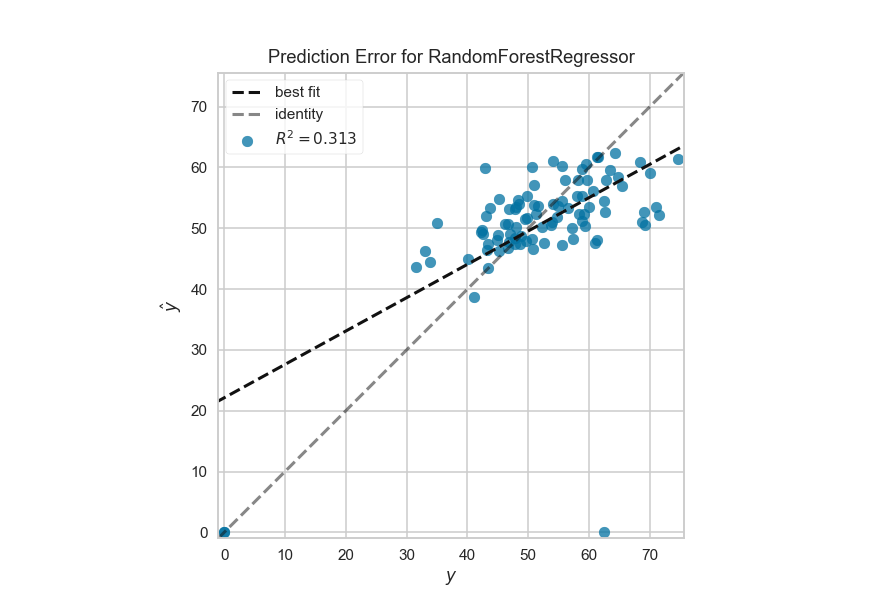

In [53]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

visualizer = PredictionError(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=95,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=1350, n_jobs=None,
           oob_score=False, random_state=38, verbose=0, warm_start=False))

visualizer.fit(XSchPct_train, ySchPct_train)  # Fit the training data to the visualizer
visualizer.score(XSchPct_test, ySchPct_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

We should note the extreme outlier with a y of ~ 62 and a yhat of 0. This point should later be more thoroughly examined.

### Model 5 - Support Vector Regression: ACT

In [44]:
# Brett's directory
# Laptop
%cd "C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets"

# Ryan's directory
#%cd "C:\Users\Clovis\Documents\7331DataMining\EducationDataNC\2017\Machine Learning Datasets"

# Cho's directory
#%cd "/Users/chostone/Documents/Data Mining/7331DataMining/EducationDataNC/2017/Machine Learning Datasets"

# NW directory
#%cd "C:\Users\Nicole Wittlin\Documents\Classes\MSDS7331\Project\2017\Machine Learning Datasets"
dfPublicHS = pd.read_csv("PublicHighSchools2017_ML.csv")

# Target variable
y = dfPublicHS['ACT Score']

# Credit: https://www.kaggle.com/saravanann/santander
# Drop any columns that have zero variance
totalColNum = dfPublicHS.shape[1]
sel = VarianceThreshold()
sel.fit(dfPublicHS)
keepCols = sel.get_support(indices=True)
dfColIndex = np.arange(dfPublicHS.columns.size)
dropCol = np.delete(dfColIndex, keepCols)
dfPublicHS = dfPublicHS.drop(dfPublicHS.columns[dropCol], axis = 1)

print("Columns Dropped: {}".format(len(dropCol)))

# These names seem to cause problems so let's give them friendlier names
renameCols = {'_1yr_tchr_trnovr_pct': 'One_yr_tchr_trnovr_pct',
              '0-3 Years_LEA_Exp_Pct_Prin': 'less_3_years_LEA_Exp_Pct_Prin',
              '10+ Years_LEA_Exp_Pct_Prin': 'ten_plus_years_LEA_Exp_Pct_Prin',
              '4-10 Years_LEA_Exp_Pct_Prin': 'four_plus_years_LEA_Exp_Pct_Prin',
              '4-Year_Cohort_Graduation_Rate_Score': 'four_Year_Cohort_Graduation_Rate_Score',
              '_1_to_1_access_Yes': 'one_to_one_access_yes',
              '4_10_Years_LEA_Exp_Pct_Prin': 'Four_to_Ten_Years_Exp_Pct_prin',
              '10+_Years_LEA_Exp_Pct_Prin': 'Ten_Plus_Years_LEA_Exp_Pct_prin',
              '0_3_Years_LEA_Exp_Pct_Prin': 'One_to_three_lea_exp_pct_prin'}

# Remove any trailing white spaces
dfPublicHS.columns = dfPublicHS.columns.str.strip()

# Remove any spaces, slashes, or hyphens
dfPublicHS.columns = dfPublicHS.columns.str.replace(r' |/|-|,|\+|:', "_")

# Rename columns
dfPublicHS.rename(columns=renameCols, inplace = True)

C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets
Columns Dropped: 1


In [45]:
# Drop any remaining variables related to the ACT score (such as ACT benchmarks) to not bias our model
dropCols = dfPublicHS.filter(regex = r'ACT')
dfPublicHS.drop(dropCols, axis = 1, inplace = True)

# Data
X = dfPublicHS.iloc[:,0:dfPublicHS.shape[1] - 1]

In [46]:
# Credit: https://www.kaggle.com/cast42/select-features-rfecv/code
p = 40
selectF_regression = SelectPercentile(f_regression, percentile=p).fit(X, y)
select_mutual = SelectPercentile(mutual_info_regression, percentile=p).fit(X, y)

f_regression_selected = selectF_regression.get_support()
f_regression_selected_features = [ f for i,f in enumerate(X.columns) if f_regression_selected[i]]
print('f_regression selected {} features.'.format(f_regression_selected.sum()))

mutual_selected = select_mutual.get_support()
mutual_selected_features = [ f for i,f in enumerate(X.columns) if mutual_selected[i]]
print('Mutual Info Regression selected {} features.'.format(mutual_selected.sum()))

selected = f_regression_selected & mutual_selected
print('Intersection of F_Regression & Mutual Info Regression: {} features'.format(selected.sum()))
featuresFull = [ f for f,s in zip(X.columns, selected) if s]

f_regression selected 126 features.
Mutual Info Regression selected 126 features.
Intersection of F_Regression & Mutual Info Regression: 89 features


In [47]:
cv = ShuffleSplit(n_splits = 10, test_size  = 0.2, random_state = 42)

X_train, X_test, y_train, y_test = train_test_split(X[featuresFull], y, random_state=42, test_size=.2)

<IPython.core.display.Javascript object>


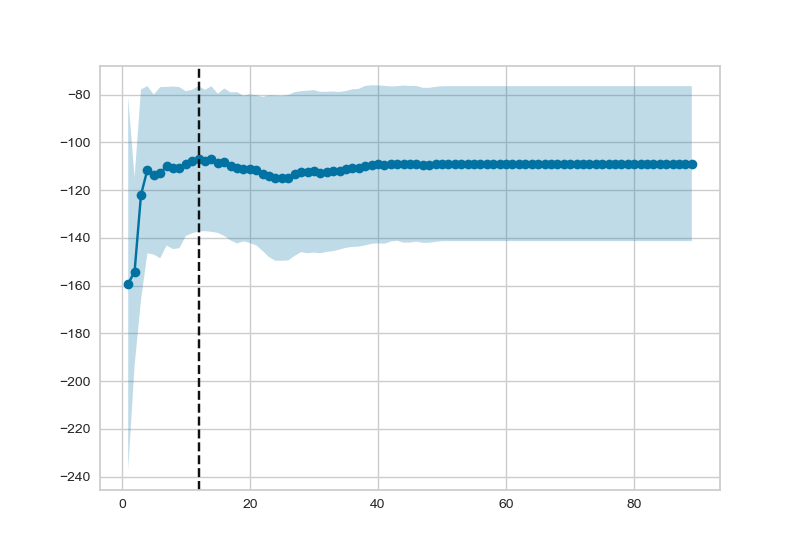

The optimal number of features is 12


In [48]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

selector = RFECV(Lasso(), cv = cv, scoring='neg_mean_squared_error')
selector.fit(X_train, y_train)

print('The optimal number of features is {}'.format(selector.n_features_))
featuresLasso = [f for f,s in zip(X_train.columns, selector.support_) if s]

#sendSlackMessage("RFE finished", "Brett")

<IPython.core.display.Javascript object>


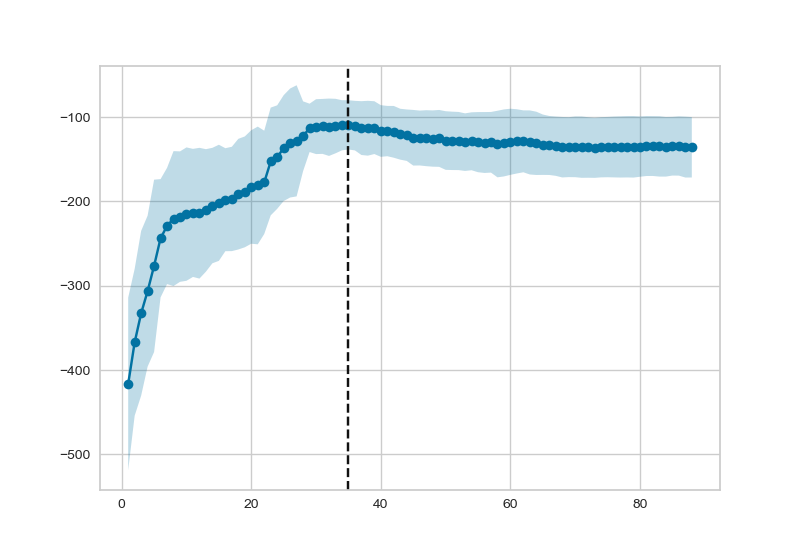

The optimal number of features is 35


In [22]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Feature Selection
selector = RFECV(Ridge(), cv = cv, scoring = 'neg_mean_squared_error')
selector.fit(X_train, y_train)

print('The optimal number of features is {}'.format(selector.n_features_))
featuresLR = [f for f,s in zip(X_train.columns, selector.support_) if s]

#sendSlackMessage("RFE finished", "Brett")

In [23]:
featureList = [featuresFull, featuresLasso, featuresLR]

<IPython.core.display.Javascript object>


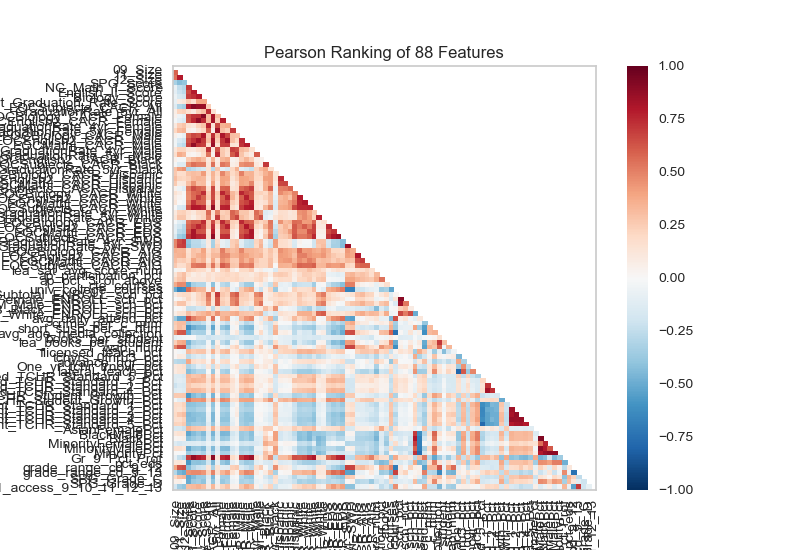

In [24]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

vis = Rank2D(features=featuresFull, algorithm='pearson', ax = ax)

vis.fit(dfPublicHS[featuresFull], y)
vis.transform(dfPublicHS[featuresFull])
vis.poof()

<IPython.core.display.Javascript object>


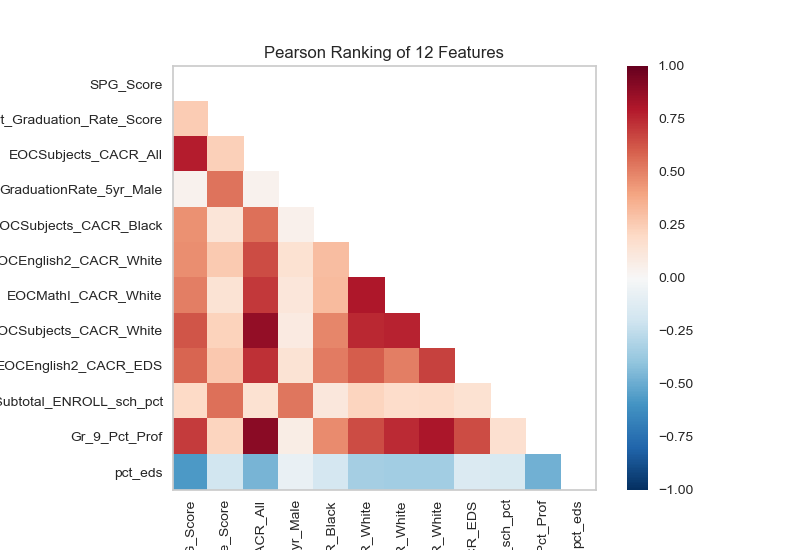

In [25]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

vis = Rank2D(features=featuresLasso, algorithm='pearson', ax = ax)

vis.fit(dfPublicHS[featuresLasso], y)
vis.transform(dfPublicHS[featuresLasso])
vis.poof()

<IPython.core.display.Javascript object>


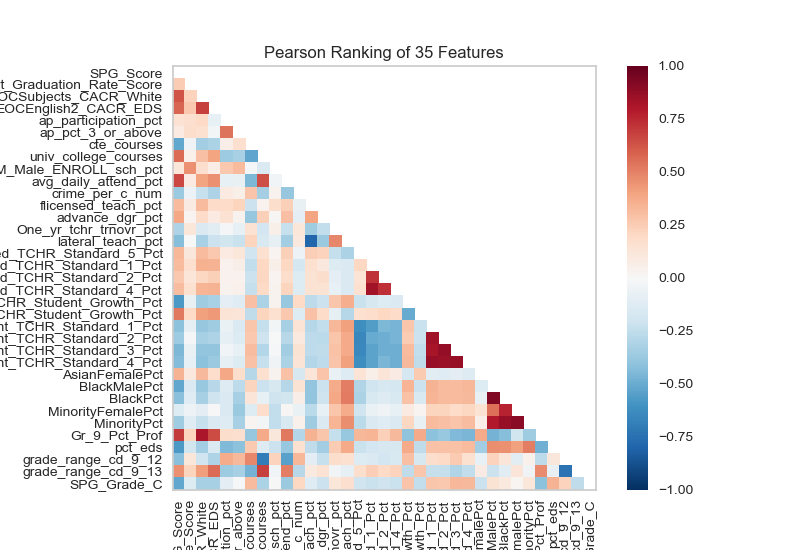

In [28]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

vis = Rank2D(features=featuresLR, algorithm='pearson', ax = ax)

vis.fit(dfPublicHS[featuresLR], y)
vis.transform(dfPublicHS[featuresLR])
vis.poof()

In [51]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regression', SVR())
])

parameters = {
    'regression__gamma': np.logspace(-2, -1, num = 20),
    'regression__epsilon': np.linspace(0, 1, num = 10),
    'regression__C': [1, 10, 100, 1000],
    'regression__kernel': ['rbf']
}

# Set parameter turning values and create a grid of models to run
scorer = make_scorer(mean_squared_error, greater_is_better = False)
gridSearch = GridSearchCV(pipeline, parameters, cv = 10, scoring = scorer, verbose = 1, n_jobs = -1)

In [57]:
from time import time

for f in featureList:
    print("Performing grid search...")
    #print("pipeline:", [name for name, _ in pipeline.steps])
    #print("parameters:")

    #pprint(parameters)
    t0 = time()

    gridSearch.fit(X[f], y)
    print("done in %0.3fs" % (time() - t0))
    #print()

    print("Best score: %0.3f" % gridSearch.best_score_)
    print("Best parameters set:")
    best_parameters = gridSearch.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
       print("\t%s: %r" % (param_name, best_parameters[param_name]))

    gridEstimator = gridSearch.best_estimator_

    EvaluateRegressionEstimator(gridEstimator, X[f], y, cv)

Performing grid search...
Fitting 10 folds for each of 800 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 510 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2110 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 3210 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 4510 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 6010 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 7710 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:   21.7s finished


done in 21.914s
Best score: -136.009
Best parameters set:
	regression__C: 100
	regression__epsilon: 0.5555555555555556
	regression__gamma: 0.01
	regression__kernel: 'rbf'
The average MAE for all cv folds is: 			 8.0342
The average MAE percentage (MAPE) for all cv folds is: 	 14.081
The average RMSE for all cv folds is: 			 11.726
*********************************************************
Cross Validation Fold Mean Error Scores
Performing grid search...
Fitting 10 folds for each of 800 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 2640 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 5440 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:   12.7s finished


done in 12.888s
Best score: -113.295
Best parameters set:
	regression__C: 100
	regression__epsilon: 1.0
	regression__gamma: 0.01
	regression__kernel: 'rbf'
The average MAE for all cv folds is: 			 7.2911
The average MAE percentage (MAPE) for all cv folds is: 	 13.215
The average RMSE for all cv folds is: 			 11.267
*********************************************************
Cross Validation Fold Mean Error Scores
Performing grid search...
Fitting 10 folds for each of 800 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 2752 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 4552 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 6752 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:   15.2s finished


done in 15.339s
Best score: -115.316
Best parameters set:
	regression__C: 100
	regression__epsilon: 0.5555555555555556
	regression__gamma: 0.01
	regression__kernel: 'rbf'
The average MAE for all cv folds is: 			 7.525
The average MAE percentage (MAPE) for all cv folds is: 	 13.66
The average RMSE for all cv folds is: 			 11.046
*********************************************************
Cross Validation Fold Mean Error Scores


### Model 6 - Support Vector Regression: Post-secondary School Enrollment Percentage

In [58]:
# Brett's directory
# Laptop
%cd "C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets"

# Ryan's directory
#%cd "C:\Users\Clovis\Documents\7331DataMining\EducationDataNC\2017\Machine Learning Datasets"

# Cho's directory
#%cd "/Users/chostone/Documents/Data Mining/7331DataMining/EducationDataNC/2017/Machine Learning Datasets"

# NW directory
#%cd "C:\Users\Nicole Wittlin\Documents\Classes\MSDS7331\Project\2017\Machine Learning Datasets"
dfPublicHS = pd.read_csv("PublicHighSchools2017_ML.csv")

# Target data
y = dfPublicHS['ALL_All Students (Total or Subtotal_ENROLL_sch_pct']

# Credit: https://www.kaggle.com/saravanann/santander
# Drop any columns that have zero variance
totalColNum = dfPublicHS.shape[1]
sel = VarianceThreshold()
sel.fit(dfPublicHS)
keepCols = sel.get_support(indices=True)
dfColIndex = np.arange(dfPublicHS.columns.size)
dropCol = np.delete(dfColIndex, keepCols)
dfPublicHS = dfPublicHS.drop(dfPublicHS.columns[dropCol], axis = 1)

print("Columns Dropped: {}".format(len(dropCol)))

# These names seem to cause problems so let's give them friendlier names
renameCols = {'_1yr_tchr_trnovr_pct': 'One_yr_tchr_trnovr_pct',
              '0-3 Years_LEA_Exp_Pct_Prin': 'less_3_years_LEA_Exp_Pct_Prin',
              '10+ Years_LEA_Exp_Pct_Prin': 'ten_plus_years_LEA_Exp_Pct_Prin',
              '4-10 Years_LEA_Exp_Pct_Prin': 'four_plus_years_LEA_Exp_Pct_Prin',
              '4-Year_Cohort_Graduation_Rate_Score': 'four_Year_Cohort_Graduation_Rate_Score',
              '_1_to_1_access_Yes': 'one_to_one_access_yes',
              '4_10_Years_LEA_Exp_Pct_Prin': 'Four_to_Ten_Years_Exp_Pct_prin',
              '10+_Years_LEA_Exp_Pct_Prin': 'Ten_Plus_Years_LEA_Exp_Pct_prin',
              '0_3_Years_LEA_Exp_Pct_Prin': 'One_to_three_lea_exp_pct_prin'}

# Remove any trailing white spaces
dfPublicHS.columns = dfPublicHS.columns.str.strip()

# Remove any spaces, slashes, or hyphens
dfPublicHS.columns = dfPublicHS.columns.str.replace(r' |/|-|,|\+|:', "_")

# Rename columns
dfPublicHS.rename(columns=renameCols, inplace = True)

C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets
Columns Dropped: 1


In [59]:
# Drop any remaining variables related to the ACT score (such as ACT benchmarks) to not bias our model
dropCols = dfPublicHS.filter(regex = r'sch_pct')
dfPublicHS.drop(dropCols, axis = 1, inplace = True)

# Data
X = dfPublicHS.iloc[:,0:dfPublicHS.shape[1] - 1]

In [60]:
# Credit: https://www.kaggle.com/cast42/select-features-rfecv/code
p = 40
selectF_regression = SelectPercentile(f_regression, percentile=p).fit(X, y)
select_mutual = SelectPercentile(mutual_info_regression, percentile=p).fit(X, y)

f_regression_selected = selectF_regression.get_support()
f_regression_selected_features = [ f for i,f in enumerate(X.columns) if f_regression_selected[i]]
print('f_regression selected {} features.'.format(f_regression_selected.sum()))

mutual_selected = select_mutual.get_support()
mutual_selected_features = [ f for i,f in enumerate(X.columns) if mutual_selected[i]]
print('Mutual Info Regression selected {} features.'.format(mutual_selected.sum()))

selected = f_regression_selected & mutual_selected
print('Intersection of F_Regression & Mutual Info Regression: {} features'.format(selected.sum()))
featuresFull = [ f for f,s in zip(X.columns, selected) if s]

f_regression selected 158 features.
Mutual Info Regression selected 158 features.
Intersection of F_Regression & Mutual Info Regression: 114 features


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X[featuresFull], y, random_state=42, test_size=.2)

<IPython.core.display.Javascript object>


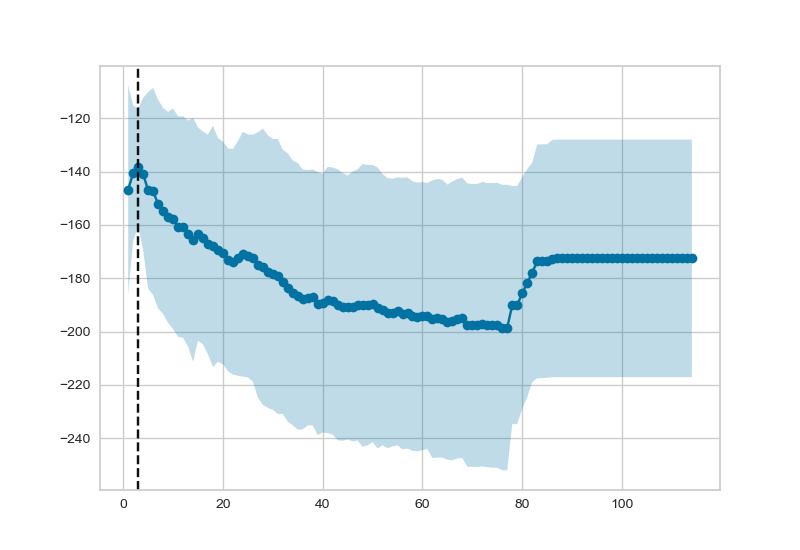

The optimal number of features is 3


In [62]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

selector = RFECV(Lasso(), cv = cv, scoring='neg_mean_squared_error')
selector.fit(X_train, y_train)

print('The optimal number of features is {}'.format(selector.n_features_))
featuresLasso = [f for f,s in zip(X_train.columns, selector.support_) if s]

#sendSlackMessage("RFE finished", "Brett")

<IPython.core.display.Javascript object>


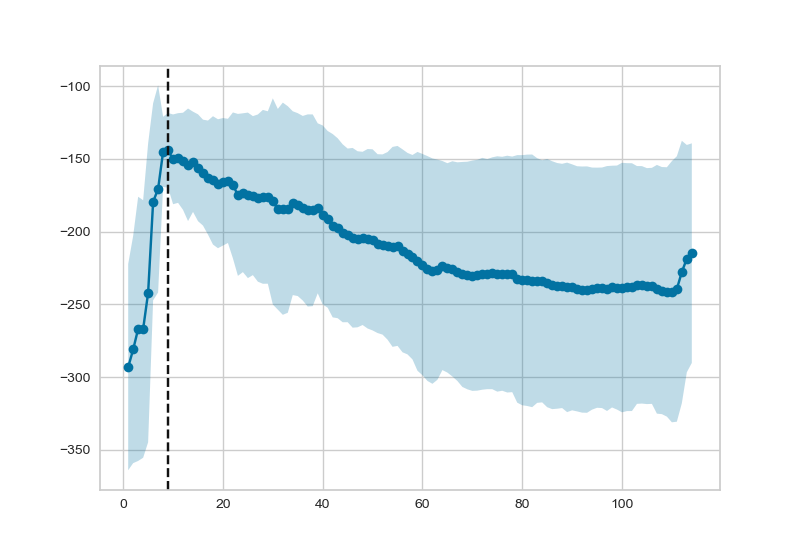

The optimal number of features is 9


In [63]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

selector = RFECV(Ridge(), cv = cv, scoring='neg_mean_squared_error')
selector.fit(X_train, y_train)

print('The optimal number of features is {}'.format(selector.n_features_))
featuresRidge = [f for f,s in zip(X_train.columns, selector.support_) if s]

#sendSlackMessage("RFE finished", "Brett")

<IPython.core.display.Javascript object>


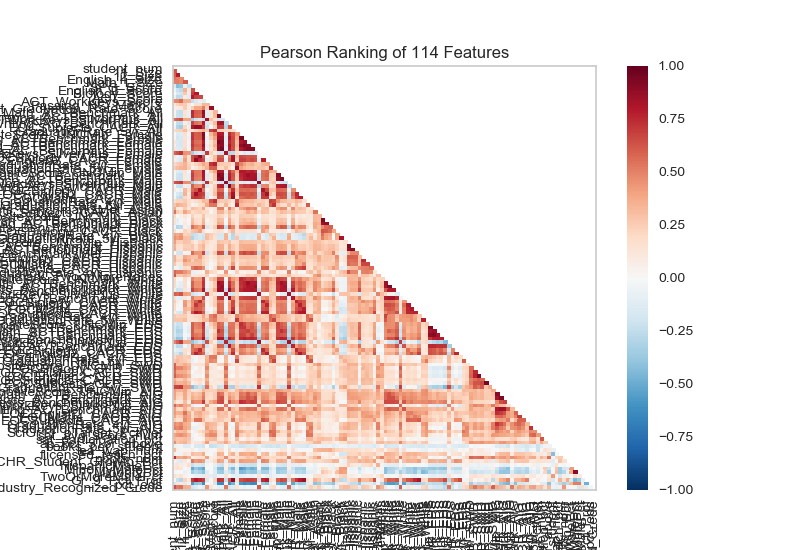

In [64]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

vis = Rank2D(features=featuresFull, algorithm='pearson', ax = ax)

vis.fit(dfPublicHS[featuresFull], y)
vis.transform(dfPublicHS[featuresFull])
vis.poof()

<IPython.core.display.Javascript object>


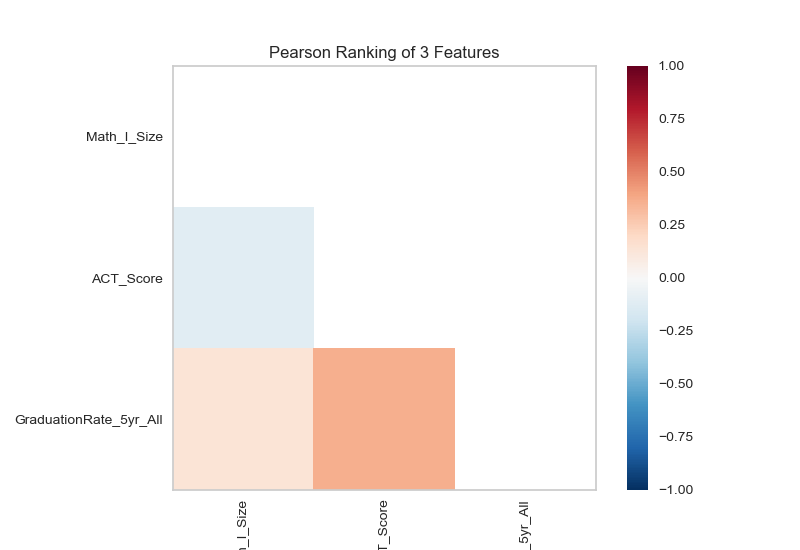

In [38]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

vis = Rank2D(features=featuresLasso, algorithm='pearson', ax = ax)

vis.fit(dfPublicHS[featuresLasso], y)
vis.transform(dfPublicHS[featuresLasso])
vis.poof()

<IPython.core.display.Javascript object>


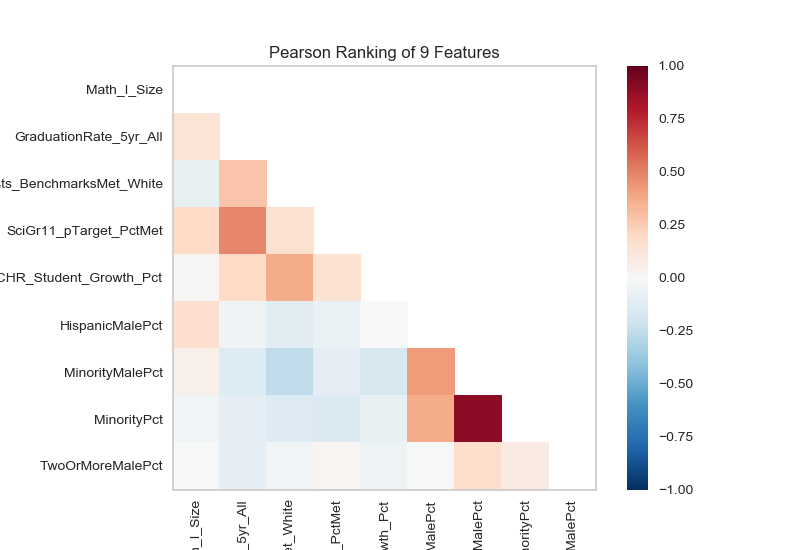

In [65]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

vis = Rank2D(features=featuresRidge, algorithm='pearson', ax = ax)

vis.fit(dfPublicHS[featuresRidge], y)
vis.transform(dfPublicHS[featuresRidge])
vis.poof()

In [66]:
featureList = [featuresFull, featuresLasso, featuresRidge]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regression', SVR())
])

parameters = {
    'regression__gamma': np.logspace(-2, -1, num = 20),
    'regression__epsilon': np.linspace(0, 1, num = 10),
    'regression__C': [1, 10, 100, 1000],
    'regression__kernel': ['rbf']
}

# Set parameter turning values and create a grid of models to run
scorer = make_scorer(mean_squared_error, greater_is_better = False)
gridSearch = GridSearchCV(pipeline, parameters, cv = 10, scoring = scorer, verbose = 1, n_jobs = -1)

In [35]:
for f in featureList:
    print("Performing grid search...")
    #print("pipeline:", [name for name, _ in pipeline.steps])
    #print("parameters:")

    #pprint(parameters)
    t0 = time()

    gridSearch.fit(X[f], y)
    print("done in %0.3fs" % (time() - t0))
    #print()

    print("Best score: %0.3f" % gridSearch.best_score_)
    print("Best parameters set:")
    best_parameters = gridSearch.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
       print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
    gridEstimator = gridSearch.best_estimator_

    EvaluateRegressionEstimator(gridEstimator, X[f], y, cv)

Performing grid search...
Fitting 10 folds for each of 800 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 287 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 787 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1487 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2387 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 3487 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 4787 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 6287 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 7977 out of 8000 | elapsed:   54.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:   54.3s finished


done in 54.413s
Best score: -174.836
Best parameters set:
	regression__C: 100
	regression__epsilon: 1.0
	regression__gamma: 0.01
	regression__kernel: 'rbf'
The average MAE for all cv folds is: 			 9.5106
The average MAE percentage (MAPE) for all cv folds is: 	 17.194
The average RMSE for all cv folds is: 			 13.256
*********************************************************
Cross Validation Fold Mean Error Scores
Performing grid search...
Fitting 10 folds for each of 800 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1848 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 4848 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


done in 17.615s
Best score: -128.981
Best parameters set:
	regression__C: 10
	regression__epsilon: 0.1111111111111111
	regression__gamma: 0.08858667904100823
	regression__kernel: 'rbf'
The average MAE for all cv folds is: 			 7.5886
The average MAE percentage (MAPE) for all cv folds is: 	 16.687
The average RMSE for all cv folds is: 			 11.131
*********************************************************
Cross Validation Fold Mean Error Scores
Performing grid search...
Fitting 10 folds for each of 800 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2152 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 5652 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 7359 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 7977 out of 8000 | elapsed:   38.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:   39.0s finished


done in 39.202s
Best score: -118.241
Best parameters set:
	regression__C: 1000
	regression__epsilon: 0.0
	regression__gamma: 0.01
	regression__kernel: 'rbf'
The average MAE for all cv folds is: 			 7.5918
The average MAE percentage (MAPE) for all cv folds is: 	 15.719
The average RMSE for all cv folds is: 			 10.783
*********************************************************
Cross Validation Fold Mean Error Scores


<a href="#top">Back to Top</a> 
<a id="Model4"></a>
### Modeling and Evaluation 4

#### ACT Score Model Evaluation

| Regression Model |   MAE  |  MAPE  |  RMSE  |
|:-----------------|-------:|-------:|-------:|
| KNN              | 8.638  | 17.137 | 11.7   |
| RF               | 6.666  | 12.604 | 9.462  |
| SVR              | 11.267 | 13.215 | 11.267 |

This is a summary of the Mean Absolute Error (MAE), the Mean Absolute Percentage Error (MAPE), and the Root Mean Square Error (RMSE) for each of the three models built to predict the ACT score for each school in the data set. For the metrics noted, the optimal value is the lowest. Thus, the best ACT score prediction model is the Random Forest. 

<IPython.core.display.Javascript object>


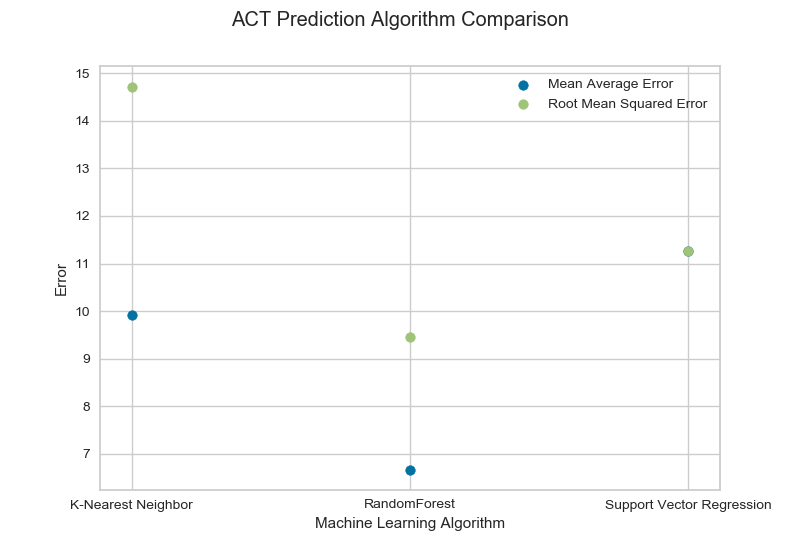

In [4]:
mae = [9.913, 6.666, 11.267]
rmse = [14.702, 9.462, 11.2687]
pts = ['K-Nearest Neighbor', 'RandomForest', 'Support Vector Regression']
leg = ['Mean Average Error', 'Root Mean Squared Error']

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('ACT Prediction Algorithm Comparison')
ax = fig.add_subplot(111)
plt.scatter(pts, mae)
plt.scatter(pts, rmse)
ax.set_xticklabels(pts)
ax.legend(leg)
ax.set_xlabel('Machine Learning Algorithm')
ax.set_ylabel('Error')
plt.show()

#### Analysis
Based on the results above, it is clear that the Random Forest model performs best in predicting each target variable. In the table and then in the graph, we see that Random Forest has a Mean Average Error of 6.66 and Root Mean Square Error of 9.46. This shows that using the Random Forest model we can predict a school's ACT average score on average within 10 points. The Support Vector Regression model will predict a school's ACT average score on average within 11 points. Which is approximately within 10% of the real value on average.

#### Postsecondary School Enrollment Percentage Model Evaluation

| Regression Model |   MAE  |  MAPE  |  RMSE  |
|------------------|:------:|:------:|:------:|
| KNN              |  8.289 | 14.971 | 12.325 |
| RF               |  6.682 | 13.972 | 10.287 |
| SVR              |  7.592 | 15.719 | 10.783 |

<IPython.core.display.Javascript object>


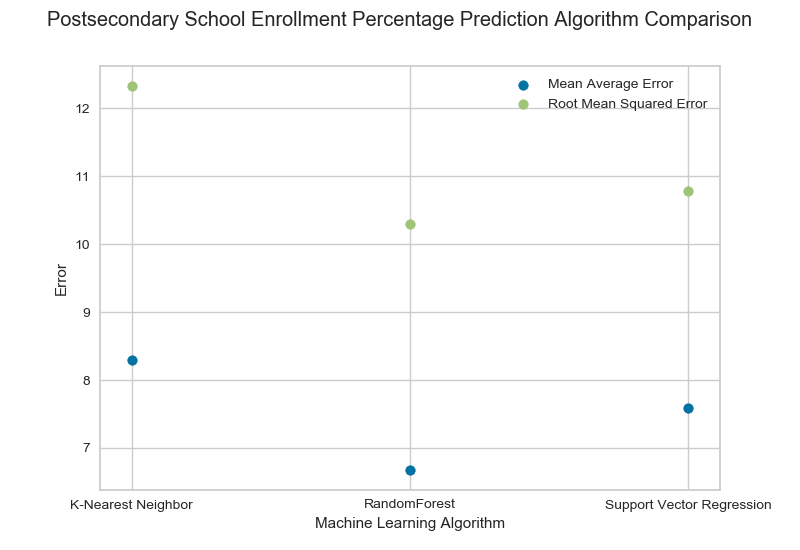

In [5]:
mae = [8.289, 6.68, 7.59]
rmse = [12.325, 10.29, 10.78]
pts = ['K-Nearest Neighbor', 'RandomForest', 'Support Vector Regression']
leg = ['Mean Average Error', 'Root Mean Squared Error']

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Postsecondary School Enrollment Percentage Prediction Algorithm Comparison')
ax = fig.add_subplot(111)
plt.scatter(pts, mae)
plt.scatter(pts, rmse)
ax.set_xticklabels(pts)
ax.legend(leg)
ax.set_xlabel('Machine Learning Algorithm')
ax.set_ylabel('Error')
plt.show()

#### Analysis
Based on the results above, it is clear that the Random Forest model performs best in predicting each target variable. In the table and then in the graph, we see that Random Forest has a Mean Average Error of 6.68 and Root Mean Square Error of 10.29. This shows that using the Random Forest model we can predict a school's postsecondary enrollment percentage on average within 10 percentage points. The Support Vector Regression model will predict a school's postsecondary enrollment percentage on average within 11 points. Which is approximately within 10% of the real value on average.

<a href="#top">Back to Top</a> 
<a id="Model5"></a>
### Modeling and Evaluation 5

#### K-Nearest Neighbor
K-Nearest Neighbor (KNN) models are a non-parametric technique that can be used for both classification and regression. It is part of instance-based learning methods, which use specific training instances to make predictions withouth having to maintain a model. KNN is also considered a "lazy learner," which delays the process of modeling until the need arises to classify test examples. Advantages of KNN include:
- Predictions made on local information
- Arbitrarily shaped decision boundaries provide more flexible model representation (compared to decision trees)
- Zero cost of learning process; all the cost in prediction computation

Citation: http://www.cs.upc.edu/~bejar/apren/docum/trans/03d-algind-knn-eng.pdf; Tan, Pang-Ning, Steinbach, Michael, and Kumar, Vipin (2006), Introduction To Data Mining (1st ed.), Boston, MA: Person Education.

#### Random Forest
Random forests are a widely used ensemble-learning model that relies on individual decision trees trained in parallel for both classification and regression. It is considerd one of the most powerful machine learning algorithms and rivals any classification method. Random Forests are a supervised machine learning technique whose advantages include:
- Ability to transform high variance, low bias decision trees into Random Forest model that has both low variance and low bias
- Little to no risk of overlearning or overfitting due to randomness, provided test set is representative of overall data set
- Allows for thousands of input variables and has effective methods for estimating missing data
- Easy to measure the relative importance of each feature on the prediction
- Default hyperparameters produce good prediction results
- Manageable number of hyperparameters that are straightforward to understand

Citation: http://www.dataversity.net/machine-learning-algorithms-introduction-random-forests/; https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd; https://www.datasciencecentral.com/profiles/blogs/random-forests-algorithm


#### Support Vector Regression
Support Vector Regression (SVR) utilizes the same ideas as the Support Vector Machine technique but tries to predict real values of a continuous variable rather than classify a categorical one. This non-parametric model is not dependent on the distribution of the variables but rather depends on kernal functions: linear, polynomial, sigmoid, or radial basis. Advantages of SVR include:
- Construction of a non-linear model without changing explanatory variables, allowing for more interpretable models
- Flexibility in terms of the distribution of variables and the relationship between independent and dependent variables (not restricted to normally distribution or linear relationships)
- Ability to control penalty terms

An important Support  Vector concept - for both SVM classification and SVR prediction - is the maximal margin hyperplane, or the maximum margin, which will yield the optimal decision boundary. A boundary with large margins tends to have better generalization errors; a boundary with small margins tend to overfit and perform poorly on test or new data. When defining the SVR algorithm, one needs to decide on the cost parameter to prevent overfitting. Low cost allows for a wide margin and a higher number of errors, where high costs allows for narrower margins and lower errors.
 
Citation: https://www.kdnuggets.com/2017/03/building-regression-models-support-vector-regression.html


<a href="#top">Back to Top</a> 
<a id="Model6"></a>
### Modeling and Evaluation 6

<span style="color: blue">Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.</span>

#### ACT

<IPython.core.display.Javascript object>


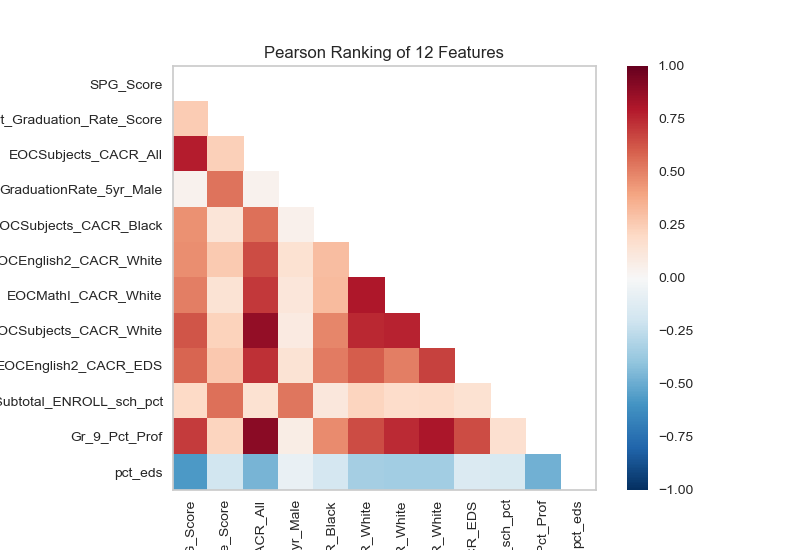

In [29]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

vis = Rank2D(features=featuresLasso, algorithm='pearson', ax = ax)

vis.fit(dfPublicHS[featuresLasso], y)
vis.transform(dfPublicHS[featuresLasso])
vis.poof()

In [30]:
for feat in featuresLasso:
    print(feat)

SPG_Score
4_Year_Cohort_Graduation_Rate_Score
EOCSubjects_CACR_All
GraduationRate_5yr_Male
EOCSubjects_CACR_Black
EOCEnglish2_CACR_White
EOCMathI_CACR_White
EOCSubjects_CACR_White
EOCEnglish2_CACR_EDS
ALL_All_Students_(Total_or_Subtotal_ENROLL_sch_pct
Gr_9_Pct_Prof
pct_eds


Using Recursive Feature Elimination with Lasso we see that the number of important attributes has been reduced down to twelve. We can break these attributes into three different categories. The first category looks at the performance of the school in English, Math, and 9th grade proficiency on average. The second category deals with the percentage of students that go on to postsecondary education. And the last category deals with the percentage of students that are economically disadvanted or a minority. The first and second categories are positive predictors that will likely indicate a higher ACT score. The third category are negative indicators that will likely indicate a lower ACT score. 

#### Postsecondary Enrollment Percentage

<IPython.core.display.Javascript object>


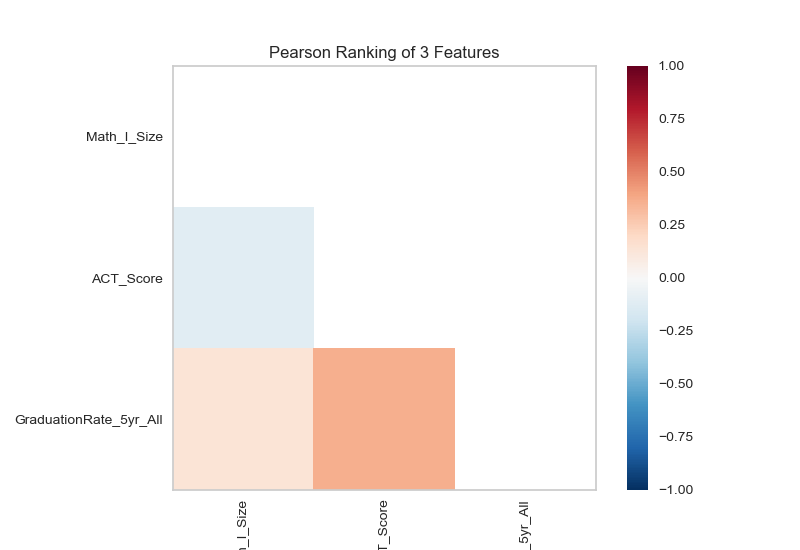

In [40]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

vis = Rank2D(features=featuresLasso, algorithm='pearson', ax = ax)

vis.fit(dfPublicHS[featuresLasso], y)
vis.transform(dfPublicHS[featuresLasso])
vis.poof()

In [41]:
for feat in featuresLasso:
    print(feat)

Math_I_Size
ACT_Score
GraduationRate_5yr_All


Using Recursive Feature Elimination with Lasso we see that the number of important attributes has been reduced down to three. Using just three attributes, we can predict on average the postsecondary enrollment percentage within 10%. Math and ACT scores are good indicators that students may go on to post-secondary education and as such are positive indicators. The graduation rate will influence the percentage as smaller schools will have a more dramatic impact on the enrollment percentage than schools with a larger number of students graduating.

<a href="#top">Back to Top</a> 
<a id="Deployment"></a>
## Deployment

The team originally set out to understand what might be influencing a "leaky pipeline" in the state of North Carolina as it relates to high school student progressing from high school into post-secondary education. While this analysis just begins to scratch the surface of understanding the various factors that both positively and negatively whether or not students progress to college, it is a solid start in understanding what might be driving forces for change. 

These models could be useful to both the State of North Carolina and the Belk Endowment, as they partner in devising a plan to increase post-secondary enrollment at the school level. This analysis, of course, is only one piece of the puzzle as it looks at a very limited set of factors. Additional work could be done to segment variables to correspond to the factors that the state or the endowment can influence, such as investment in teacher education and credentials or improvement in test preparation or school performance or targeted learning programs for different socioeconomic, demographic, or location-based factors. The performance of these models would be measured over time by evaluating individual school performance after investments in factors that the models indicate could be influenced.

The data currently being collected by the state is incredibly comprehensive and offers much insight, so there is no immediate recommendation for additional data to collect. The yearly nature of the data collection process makes this a long-term project, as there is not new data being added to the analysis at frequent intervals, and thus the models would be updated annually.

<a href="#top">Back to Top</a> 
<a id="Exceptional"></a>
## Exceptional Work

#### Exceptional Work
- Pipeline
- Hyperparameter tuning using GridSearchCV
- Use of Yellowbrick graphs to refine the range of hyperparameters

To improve our models, beyond arbitrarily changing parameters and re-running models to attempt to lower the error rate, we used the package Yellowbrick to guide us visually to an optimal range of parameter values. For each hyperparameter we planned to tune, we set a range to visually check the Mean Absolute Error for each value. The resulting smaller range of values can now be used to hypertune in GridSearchCV.

GridSearchCV accepts ranges of values for parameters you plan to hypertune and make a model for each. It can then display the set of parameters that yielded the best score.

For K-Nearest Neighbor regression, the models were initially run to find an appropriate k value. Then k (n_neighbors), p (power parameter), and the weights of k were hypertuned. The definitions of these parameters are: 
- n_neighbors - Also known as k. This is the number of samples that will be retrieved around a new sample; those will be averaged in regression to yield a prediction for the new sample.
- p - The power parameter is set to 1 for Manhattan distance and 2 for Euclidean distance.
- weights - This parameter can be set to 'uniform' where all points in a k neighborhood are weighted the same. It can also be set to 'distance' so the points are weighed inversely to their distance from the new point.

Citation: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html; 
http://scikit-learn.org/stable/modules/neighbors.html#regression

Since the Random Forest algorithm is much more computationally intensive, it is not feasible to feed a wide range of parameter values into GridSearchCV. Because of this, we initially used RandomizedGridSearchCV, which does not use the entire data to test the models like GridSerachCV. Instead, it samples a small portion of the data. We used a larger range of parameter values for RandomizedGridSearchCV to start and then refined that range based on the results to then be used in GridSearchCV. The hypertuned parameters we used for our Random Forest regression are:
- n_estimators - This parameter adjusts how many decision trees are in the forest. This will always mean the more trees, the better the model. But as this increases, the trade-off is time, as the computations needed increases drastically.
- max_depth - This parameter adjusts how deep the decision trees are allowed to have. If the max depth is set to none then the nodes will expand until all the leaves are pure or when all the leaves have less than the min_samples_split samples.
- min_samples_split - This parameter sets the minimum number of samples required to split a node.
- min_samples_leaf - This parameter sets the minimum number of samples neeed to make a leaf node on both the left and right node of the split. This might affect model smoothing in regression.

Citation:
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html;
http://scikit-learn.org/stable/modules/ensemble.html#forest